# %% [markdown]

 # Calculating Trigger ~ `UNIT` frequencies and AMs directly from final parquets
 initiated: _January 16, 2025_
 > The previously authored notebook `calc_trigger_AM.*` relies on `UCS` command line tools,
 > which this attempt will not, thereby simplifying the pipeline and file outputs.

 Loading imports

In [ ]:
from am_notebooks import *
from source.utils.LexicalCategories import SPECIAL_ADV
from association_measures import frequencies as amfq, measures as amms

L1 = 'trigger_lemma'
L2 = 'adv_form_lower'

HIT_DATA_DIR = Path('/share/compling/data/sanpi/2_hit_tables')
NEG_SUPER_PARQ = HIT_DATA_DIR.joinpath('RBdirect/ALL-RBdirect_final.parq')
POS_SUPER_PARQ = HIT_DATA_DIR.joinpath(
    'not-RBdirect/ALL_not-RBdirect_final.parq')
NEG_MIRROR_PARQ = HIT_DATA_DIR.joinpath('NEGmirror/ALL-NEGmirror_final.parq')
POS_MIRROR_PARQ = HIT_DATA_DIR.joinpath('POSmirror/ALL-POSmirror_final.parq')


def rename_trigger_dep_info(df):
    if df.filter(['neg_head', 'mir_head', 'neg_deprel', 'mir_deprel']).empty:
        return df
    return df.assign(
        trigger_head=df.filter(
            ['neg_head', 'mir_head']).iloc[:, 0],
        trigger_deprel=df.filter(
            ['neg_deprel', 'mir_deprel']).iloc[:, 0],
    )


def fix_word_null(df):
    """Fix null values in adjective and adverb columns.

    This function replaces null values in 'adj_form_lower' and 'adv_form_lower'
    columns of a DataFrame with the string 'null'. 
    That is, these are cases where the string "null" 
    was improperly interpreted as '<NA>' rather than the literal word, "null".

    Args:
        df: Pandas DataFrame containing 'adj_form_lower' and 'adv_form_lower' columns.

    Returns:
        Pandas DataFrame with null values in specified columns replaced with 'null'.
    """

    return df.assign(adj_form_lower=df.adj_form_lower.fillna('null'),
                     adv_form_lower=df.adv_form_lower.fillna('null'),
                     trigger_lower=df.trigger_lower.fillna('null'))


def load_trigger_info(parq_paths):
    sources = []
    trig_node = 'neg'
    polarity = 'neg'
    for path in parq_paths:
        if 'POS' in path.stem:
            trig_node = 'mir'
            polarity = 'pos'
        _df = pd.read_parquet(
            path, engine='pyarrow',
            columns=pd.Series(
                [L1, L2] +
                ['trigger_lemma', 'trigger_lower', 'bigram_lower',
                 f'{trig_node}_head', f'{trig_node}_deprel',
                 'adv_form_lower', 'adj_form_lower', 'bigram_id']
            ).drop_duplicates().to_list())
        _df = rename_trigger_dep_info(_df)
        _df = _df.assign(polarity=polarity).convert_dtypes()
        sources.append(_df)
    trigger_df = pd.concat(sources) if len(sources) > 1 else sources[0]
    trigger_df = trigger_df.loc[:, ~
                                trigger_df.columns.str.startswith(('neg_', 'mir_'))]
    trigger_df = fix_word_null(trigger_df)
    if any(trigger_df.trigger_lemma.str.startswith('ain')):
        aint_triggered = trigger_df.trigger_lemma.isin(["ain't", "aint"])
        trigger_df.loc[aint_triggered, :] = trigger_df.loc[aint_triggered, :].assign(
            trigger_lemma='not')
    trigger_df.info()
    return trigger_df

In [ ]:
# %%

df_super_neg = load_trigger_info([NEG_SUPER_PARQ])
df_super_neg.describe().T.iloc[:, 1:].convert_dtypes()

<class 'pandas.core.frame.DataFrame'>
Index: 3188297 entries, apw_eng_19971117_0849_61:4-6-7 to pcc_eng_val_3.10643_x51716_28:5-7-8
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   trigger_lemma   string
 1   adv_form_lower  string
 2   trigger_lower   string
 3   bigram_lower    string
 4   adj_form_lower  string
 5   bigram_id       string
 6   trigger_head    string
 7   trigger_deprel  string
 8   polarity        string
dtypes: string(9)
memory usage: 243.2+ MB


,unique,top,freq
trigger_lemma,15,not,2871807
adv_form_lower,5579,as,533878
trigger_lower,54,not,2005270
bigram_lower,187832,as_good,44635
adj_form_lower,28060,good,131430
bigram_id,3188297,apw_eng_19971126_1587_35:7-8,1
trigger_head,2,ADJ,3101239
trigger_deprel,33,advmod,2701472
polarity,1,neg,3188297


In [ ]:
#%%

def display_trigger_totals(_df, dataset = 'superset', polar ='negative', cross='lower'):
    for_sty = _df.groupby('trigger_lemma').value_counts(
        [f'trigger_{cross}']).to_frame()
    if cross == 'head': 
        cross_name = 'dependency head'  
        for_sty = for_sty.unstack().fillna(0).convert_dtypes()
    else: 
        cross_name = 'case-normalized form'
    save_latex_table(
        sty=format_zeros(for_sty
            .style
            .background_gradient(axis=0, cmap='YlGnBu')
            .format(precision=1, thousands=',', escape='latex')),
        caption=(f'{dataset} {polar} Trigger Lemma Frequencies by {cross_name}'.title()),
        label=f'trig-lemma-{cross}-{dataset[:3]}-{polar[:3]}',
        longtable=True,
        latex_subdir='triggers',
        latex_stem=f'trigger_lemma-{cross}_counts_{dataset[:3]}-{polar[:3]}')

display_trigger_totals(df_super_neg, cross='head')

Superset Negative Trigger Lemma Frequencies By Dependency Head
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trigger_lemma-head_counts_sup-neg.2025-01-22.tex


Stylized latex table saved as:
  latex/tables/triggers/trigger_lemma-head_counts_sup-neg.2025-01-22.tex



In [ ]:
# %%

display_trigger_totals(df_super_neg)

Superset Negative Trigger Lemma Frequencies By Case-Normalized Form
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trigger_lemma-lower_counts_sup-neg.2025-01-22.tex


Stylized latex table saved as:
  latex/tables/triggers/trigger_lemma-lower_counts_sup-neg.2025-01-22.tex



In [ ]:
# %%

df_mirror = load_trigger_info([NEG_MIRROR_PARQ, POS_MIRROR_PARQ])
df_mirror.describe().T.iloc[:, 1:].convert_dtypes()

<class 'pandas.core.frame.DataFrame'>
Index: 1689780 entries, apw_eng_19941117_0297_31:3-4-5 to pcc_eng_val_3.11049_x52389_100:30-31-32
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   trigger_lemma   1689780 non-null  string
 1   adv_form_lower  1689780 non-null  string
 2   trigger_lower   1689780 non-null  string
 3   bigram_lower    1689780 non-null  string
 4   adj_form_lower  1689780 non-null  string
 5   bigram_id       1689780 non-null  string
 6   trigger_head    1689780 non-null  string
 7   trigger_deprel  1689780 non-null  string
 8   polarity        1689780 non-null  string
dtypes: string(9)
memory usage: 128.9+ MB


,unique,top,freq
trigger_lemma,28,something,309632
adv_form_lower,5760,more,287569
trigger_lower,55,something,309483
bigram_lower,197589,more_important,23349
adj_form_lower,23315,important,43644
bigram_id,1689780,apw_eng_19941129_0516_38:17-18,1
trigger_head,3,ADJ,1293056
trigger_deprel,22,advmod,572538
polarity,2,pos,1396324


In [ ]:
# %%

# save_latex_table(
#     sty=(df_mirror.groupby(['polarity', 'trigger_lemma']).value_counts(
#         ['trigger_lower']).to_frame()
#         .style
#         .background_gradient(axis=0, cmap='purple_rain')
#         .format(precision=0, thousands=',', escape='latex')),
#     caption=(r'Mirror Subset Trigger Lemma Composition: attested forms'),
#     label='trig-lemma-vs-form-subset',
#     longtable=True,
#     latex_subdir='triggers',
#     latex_stem='mirror-trigger_lemma-form_counts')

In [ ]:
# %%

df_mirror_neg = load_trigger_info([NEG_MIRROR_PARQ])
df_mirror_neg.describe().T.iloc[:, 1:].convert_dtypes()

# save_latex_table(
#     sty=(df_mirror_neg.groupby(['polarity', 'trigger_lemma']).value_counts(
#         ['trigger_lower']).to_frame()
#         .style
#         .background_gradient(axis=0, cmap='purple_rain')
#         .format(precision=0, thousands=',', escape='latex')),
#     caption=(r'Negative Mirror Subset Trigger Lemma Composition: attested forms'),
#     label='negmir-trig-lemma-vs-form',
#     longtable=True,
#     latex_subdir='triggers',
#     latex_stem='mirror-neg-trigger_lemma-form_counts')

<class 'pandas.core.frame.DataFrame'>
Index: 293456 entries, apw_eng_19941117_0297_31:3-4-5 to pcc_eng_val_3.09952_x50620_12:13-15-16
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   trigger_lemma   293456 non-null  string
 1   adv_form_lower  293456 non-null  string
 2   trigger_lower   293456 non-null  string
 3   bigram_lower    293456 non-null  string
 4   adj_form_lower  293456 non-null  string
 5   bigram_id       293456 non-null  string
 6   trigger_head    293456 non-null  string
 7   trigger_deprel  293456 non-null  string
 8   polarity        293456 non-null  string
dtypes: string(9)
memory usage: 22.4+ MB


,unique,top,freq
trigger_lemma,12,never,111102
adv_form_lower,2013,more,79045
trigger_lower,20,never,111102
bigram_lower,41019,more_important,12347
adj_form_lower,8070,important,14913
bigram_id,293456,apw_eng_19941113_0042_8:8-9,1
trigger_head,2,ADJ,216433
trigger_deprel,18,advmod,120867
polarity,1,neg,293456


In [ ]:
# %%

df_mirror_pos = load_trigger_info([POS_MIRROR_PARQ])
df_mirror_pos.describe().T.iloc[:, 1:].convert_dtypes()
# save_latex_table(
#     sty=(df_mirror_pos.groupby(['polarity', 'trigger_lemma']).value_counts(
#         ['trigger_lower']).to_frame()
#         .style
#         .background_gradient(axis=0, cmap='purple_rain')
#         .format(precision=0, thousands=',', escape='latex')),
#     caption=(r'Negative Mirror Subset Trigger Lemma Composition: attested forms'),
#     label='posmir-trig-lemma-vs-form',
#     longtable=True,
#     latex_subdir='triggers',
#     latex_stem='mirror-pos-trigger_lemma-form_counts')

<class 'pandas.core.frame.DataFrame'>
Index: 1396324 entries, apw_eng_19941121_0258_30:1-4-5 to pcc_eng_val_3.11049_x52389_100:30-31-32
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   trigger_lemma   1396324 non-null  string
 1   adv_form_lower  1396324 non-null  string
 2   trigger_lower   1396324 non-null  string
 3   bigram_lower    1396324 non-null  string
 4   adj_form_lower  1396324 non-null  string
 5   bigram_id       1396324 non-null  string
 6   trigger_head    1396324 non-null  string
 7   trigger_deprel  1396324 non-null  string
 8   polarity        1396324 non-null  string
dtypes: string(9)
memory usage: 106.5+ MB


,unique,top,freq
trigger_lemma,16,something,309632
adv_form_lower,5322,more,208524
trigger_lower,35,something,309483
bigram_lower,178916,as_simple,14992
adj_form_lower,21484,different,34454
bigram_id,1396324,apw_eng_19941130_0060_59:16-17,1
trigger_head,2,ADJ,1076623
trigger_deprel,20,advmod,451671
polarity,1,pos,1396324


In [ ]:
# %%

bare_cols = [
    'polarity', L1, L2,
    'trigger_lemma', 'adv_form_lower',
    'adj_form_lower', 'trigger_head',
    'trigger_lower', 'bigram_id'
]
all_trigger_info = pd.concat(
    [df_super_neg.filter(bare_cols),
     df_mirror.filter(bare_cols)]
).drop_duplicates('bigram_id').drop(columns=['bigram_id'])

all_trigger_info

,polarity,trigger_lemma,adv_form_lower,adj_form_lower,trigger_head,trigger_lower
hit_id,,,,,,
apw_eng_19971117_0849_61:4-6-7,neg,not,as,efficient,ADJ,not
apw_eng_19971117_1368_31:3-4-5,neg,not,unusually,tight,ADJ,not
apw_eng_19971119_0580_31:08-09-10,neg,not,as,serious,ADJ,not
apw_eng_19971119_0608_44:3-4-5,neg,not,even,interested,ADJ,not
apw_eng_19971120_0232_5:3-5-6,neg,not,more,specific,ADJ,not
...,...,...,...,...,...,...
pcc_eng_val_3.10127_x50910_330:38-39-40,pos,all,very,exciting,ADJ,all
pcc_eng_val_3.10313_x51192_39:14-15-16,pos,something,as,simple,MIR,something
pcc_eng_val_3.10562_x51589_14:2-4-5,pos,everyone,so,negative,ADJ,everyone


In [ ]:
# %%

for tdf, pol, dat in [
    (df_mirror, 'any polarity', 'mirror subset'), 
    (df_mirror_neg, 'negative', 'mirror subset'), 
    (df_mirror_pos, 'positive', 'mirror subset'), 
    (all_trigger_info, 'any polarity', 'any triggered data')
    ]: 
    display_trigger_totals(tdf, polar=pol, dataset=dat, cross='head')
    display_trigger_totals(tdf, polar=pol, dataset=dat)

def add_assoc_key(_df,
                  l1: str = L1,
                  l2: str = L2):  # sourcery skip: use-fstring-for-concatenation
    _df['key'] = _df[l1] + '~' + _df[l2]
    return _df.set_index('key')


def add_marginal_cols(_df, _fdf,
                      l1: str = L1,
                      l2: str = L2):
    _fdf['f1'] = _fdf[l1].map(_df.value_counts(l1))
    _fdf['f2'] = _fdf[l2].map(_df.value_counts(l2))
    return _fdf


def get_joint_f(_df,
                l1: str = L1,
                l2: str = L2):
    fdf = _df.value_counts([l1, l2]).to_frame('f').reset_index()
    fdf = add_assoc_key(fdf, l1=l1, l2=l2).assign(N=len(_df))
    return add_marginal_cols(_fdf=fdf, _df=_df, l1=l1, l2=l2)


def calc_trigger_assoc(trigger_info_df):
    freq_df = get_joint_f(trigger_info_df)
    freq_df = freq_df.rename(columns={L1: 'l1', L2: 'l2'})
    display(set_my_style(freq_df.nlargest(10, 'f')))

    freq_df = freq_df.join(
        amfq.expected_frequencies(
            freq_df, observed=True),
        rsuffix='_X')
    freq_df = freq_df.loc[:, ~freq_df.columns.str.endswith('_X')]
    # display(set_my_style(freq_df.nlargest(10, 'f')))

    _am_df = adjust_am_names(amms.score(
        freq_df, measures=['conservative_log_ratio', 'log_likelihood']))
    _am_df['dP1'] = freq_df.apply(deltaP, axis=1)
    _am_df['dP2'] = freq_df.apply(deltaP, given=1, axis=1)
    _am_df = extend_deltaP(_am_df, extensions=('mean', 'max'))
    _am_df = _am_df.assign(
        f=freq_df.f,
        f1=freq_df.f1,
        f2=freq_df.f2,
        l1=freq_df.l1,
        l2=freq_df.l2,
    )
    # display(set_my_style(_am_df.nlargest(10, 'LRC')))

    _am_df['unexp_f'] = freq_df['f'] - \
        _am_df['exp_f']
    _am_df['unexp_r'] = (
        _am_df['f'] / _am_df['unexp_f']).apply(lambda r: max(r, -1))
    # pprint(trigger_info_df.set_index(L1).polarity.to_dict())
    _am_df['polarity'] = _am_df.l1.map(
        trigger_info_df.set_index(L1).polarity.to_dict()).astype('category')
    display(_am_df.polarity.value_counts())
    display(set_my_style(_am_df.nlargest(10, 'LRC')))
    return _am_df


am_trig_adv_super = calc_trigger_assoc(df_super_neg)

Mirror Subset Any Polarity Trigger Lemma Frequencies By Dependency Head
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trigger_lemma-head_counts_mir-any.2025-01-22.tex


Stylized latex table saved as:
  latex/tables/triggers/trigger_lemma-head_counts_mir-any.2025-01-22.tex

Mirror Subset Any Polarity Trigger Lemma Frequencies By Case-Normalized Form
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trigger_lemma-lower_counts_mir-any.2025-01-22.tex


Stylized latex table saved as:
  latex/tables/triggers/trigger_lemma-lower_counts_mir-any.2025-01-22.tex

Mirror Subset Negative Trigger Lemma Frequencies By Dependency Head
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trigger_lemma-head_counts_mir-neg.2025-01-22.tex


Stylized latex table saved as:
  latex/tables/triggers/trigger_lemma-head_counts_mir-neg.2025-01-22.tex

Mirror Subset Negative Trigger Lemma Frequencies By Case-Normalized Form
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trigger_lemma-lower_counts_mir-neg.2025-01-22.tex


Stylized latex table saved as:
  latex/tables/triggers/trigger_lemma-lower_counts_mir-neg.2025-01-22.tex

Mirror Subset Positive Trigger Lemma Frequencies By Dependency Head
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trigger_lemma-head_counts_mir-pos.2025-01-22.tex


Stylized latex table saved as:
  latex/tables/triggers/trigger_lemma-head_counts_mir-pos.2025-01-22.tex

Mirror Subset Positive Trigger Lemma Frequencies By Case-Normalized Form
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trigger_lemma-lower_counts_mir-pos.2025-01-22.tex


Stylized latex table saved as:
  latex/tables/triggers/trigger_lemma-lower_counts_mir-pos.2025-01-22.tex

Any Triggered Data Any Polarity Trigger Lemma Frequencies By Dependency Head
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trigger_lemma-head_counts_any-any.2025-01-22.tex


Stylized latex table saved as:
  latex/tables/triggers/trigger_lemma-head_counts_any-any.2025-01-22.tex

Any Triggered Data Any Polarity Trigger Lemma Frequencies By Case-Normalized Form
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trigger_lemma-lower_counts_any-any.2025-01-22.tex


Stylized latex table saved as:
  latex/tables/triggers/trigger_lemma-lower_counts_any-any.2025-01-22.tex



,l1,l2,f,N,f1,f2
key,,,,,,
not~as,not,as,"500,600","3,188,297","2,871,807","533,878"
not~so,not,so,"318,637","3,188,297","2,871,807","345,512"
not~too,not,too,"257,451","3,188,297","2,871,807","310,703"
not~very,not,very,"181,039","3,188,297","2,871,807","190,430"
not~that,not,that,"160,748","3,188,297","2,871,807","165,103"
not~only,not,only,"114,188","3,188,297","2,871,807","114,378"
not~always,not,always,"103,868","3,188,297","2,871,807","104,391"
not~really,not,really,"86,242","3,188,297","2,871,807","97,891"
not~more,not,more,"81,686","3,188,297","2,871,807","163,322"


polarity
neg    11217
Name: count, dtype: int64

,obs_f,obs_12,obs_21,obs_22,R1,R2,C1,C2,N,exp_f,exp_12,exp_21,exp_22,LRC,G2,ipm,ipm_reference,ipm_expected,dP1,dP2,deltaP_mean,deltaP_max,f,f1,f2,l1,l2,unexp_f,unexp_r,polarity
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
no~earthly,79,"12,359",5,"3,175,854","12,438","3,175,859",84,"3,188,213","3,188,297",0.33,"12,437.67",83.67,"3,175,775.33",9.21,839.0,"6,351.50",1.57,26.35,0.94,0.01,0.47,0.94,79,"12,438",84,no,earthly,78.67,1.00,neg
no~wise,51,"12,387",5,"3,175,854","12,438","3,175,859",56,"3,188,241","3,188,297",0.22,"12,437.78",55.78,"3,175,803.22",8.45,532.3,"4,100.34",1.57,17.56,0.91,0.00,0.46,0.91,51,"12,438",56,no,wise,50.78,1.00,neg
no~longer,768,"11,670",601,"3,175,258","12,438","3,175,859","1,369","3,186,928","3,188,297",5.34,"12,432.66","1,363.66","3,174,495.34",7.93,"6,694.6","61,746.26",189.24,429.38,0.56,0.06,0.31,0.56,768,"12,438","1,369",no,longer,762.66,1.01,neg
no~slam,33,"12,405",9,"3,175,850","12,438","3,175,859",42,"3,188,255","3,188,297",0.16,"12,437.84",41.84,"3,175,817.16",7.23,322.6,"2,653.16",2.83,13.17,0.78,0.00,0.39,0.78,33,"12,438",42,no,slam,32.84,1.00,neg
never~before,285,"110,804",23,"3,077,185","111,089","3,077,208",308,"3,187,989","3,188,297",10.73,"111,078.27",297.27,"3,076,910.73",6.95,"1,752.2","2,565.51",7.47,96.60,0.89,0.00,0.45,0.89,285,"111,089",308,never,before,274.27,1.04,neg
without~prior,16,"14,809",0,"3,173,472","14,825","3,173,472",16,"3,188,281","3,188,297",0.07,"14,824.93",15.93,"3,173,456.07",6.83,171.9,"1,079.26",0.00,5.02,1.00,0.00,0.50,1.00,16,"14,825",16,without,prior,15.93,1.00,neg
no~doubt,21,"12,417",5,"3,175,854","12,438","3,175,859",26,"3,188,271","3,188,297",0.10,"12,437.90",25.90,"3,175,833.10",6.66,207.6,"1,688.37",1.57,8.15,0.80,0.00,0.40,0.80,21,"12,438",26,no,doubt,20.90,1.00,neg
no~less,"4,085","8,353","9,433","3,166,426","12,438","3,175,859","13,518","3,174,779","3,188,297",52.74,"12,385.26","13,465.26","3,162,393.74",6.64,"30,312.8","328,429.01","2,970.22","4,239.88",0.30,0.33,0.31,0.33,"4,085","12,438","13,518",no,less,"4,032.26",1.01,neg
hardly~ever,698,"4,827","5,266","3,177,506","5,525","3,182,772","5,964","3,182,333","3,188,297",10.34,"5,514.66","5,953.66","3,176,818.34",5.93,"4,678.0","126,334.84","1,654.53","1,870.59",0.12,0.12,0.12,0.12,698,"5,525","5,964",hardly,ever,687.66,1.02,neg


In [ ]:
#%%

def display_trigger_totals(_df, dataset = 'superset', polar ='negative', cross='lower'):
    x = f'trigger_{cross}'
    for_sty = _df.groupby(['polarity','trigger_lemma']
                          ).value_counts([x,]).to_frame()
    if cross == 'head': 
        if _df[x].nunique() > 2: 
            _df[x] = _df[x].map({'ADJ':'ADJ', 'MIR':'TRIGGER', 'NEG': 'TRIGGER'})
        cross_name = 'dependency head'  
        for_sty = for_sty.unstack().fillna(0).convert_dtypes()
    else: 
        cross_name = 'case-normalized form'
    save_latex_table(
        sty=format_zeros(for_sty
            .style
            .background_gradient(axis=0, cmap='YlGnBu')
            .format(precision=1, thousands=',', escape='latex')),
        caption=(f'{dataset} {polar} Trigger Lemma Frequencies by {cross_name}'.title()),
        label=f'trig-lemma-{cross}-{dataset[:3]}-{polar[:3]}',
        longtable=True,
        latex_subdir='triggers',
        latex_stem=f'trigger_lemma-{cross}_counts_{dataset[:3]}-{polar[:3]}')

display_trigger_totals(df_super_neg, cross='head')

Superset Negative Trigger Lemma Frequencies By Dependency Head
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trigger_lemma-head_counts_sup-neg.2025-01-22.tex


Stylized latex table saved as:
  latex/tables/triggers/trigger_lemma-head_counts_sup-neg.2025-01-22.tex



In [ ]:
# %%

display_trigger_totals(df_super_neg)

Superset Negative Trigger Lemma Frequencies By Case-Normalized Form
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trigger_lemma-lower_counts_sup-neg.2025-01-22.tex


Stylized latex table saved as:
  latex/tables/triggers/trigger_lemma-lower_counts_sup-neg.2025-01-22.tex



In [ ]:
# %%

df_mirror = load_trigger_info([NEG_MIRROR_PARQ, POS_MIRROR_PARQ])
df_mirror.describe().T.iloc[:, 1:].convert_dtypes()

# save_latex_table(
#     sty=(df_mirror.groupby(['polarity', 'trigger_lemma']).value_counts(
#         ['trigger_lower']).to_frame()
#         .style
#         .background_gradient(axis=0, cmap='purple_rain')
#         .format(precision=0, thousands=',', escape='latex')),
#     caption=(r'Mirror Subset Trigger Lemma Composition: attested forms'),
#     label='trig-lemma-vs-form-subset',
#     longtable=True,
#     latex_subdir='triggers',
#     latex_stem='mirror-trigger_lemma-form_counts')

<class 'pandas.core.frame.DataFrame'>
Index: 1689780 entries, apw_eng_19941117_0297_31:3-4-5 to pcc_eng_val_3.11049_x52389_100:30-31-32
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   trigger_lemma   1689780 non-null  string
 1   adv_form_lower  1689780 non-null  string
 2   trigger_lower   1689780 non-null  string
 3   bigram_lower    1689780 non-null  string
 4   adj_form_lower  1689780 non-null  string
 5   bigram_id       1689780 non-null  string
 6   trigger_head    1689780 non-null  string
 7   trigger_deprel  1689780 non-null  string
 8   polarity        1689780 non-null  string
dtypes: string(9)
memory usage: 128.9+ MB


,unique,top,freq
trigger_lemma,28,something,309632
adv_form_lower,5760,more,287569
trigger_lower,55,something,309483
bigram_lower,197589,more_important,23349
adj_form_lower,23315,important,43644
bigram_id,1689780,apw_eng_19941129_0516_38:17-18,1
trigger_head,3,ADJ,1293056
trigger_deprel,22,advmod,572538
polarity,2,pos,1396324


In [ ]:
# %%

df_mirror_neg = load_trigger_info([NEG_MIRROR_PARQ])
df_mirror_neg.describe().T.iloc[:, 1:].convert_dtypes()

# save_latex_table(
#     sty=(df_mirror_neg.groupby(['polarity', 'trigger_lemma']).value_counts(
#         ['trigger_lower']).to_frame()
#         .style
#         .background_gradient(axis=0, cmap='purple_rain')
#         .format(precision=0, thousands=',', escape='latex')),
#     caption=(r'Negative Mirror Subset Trigger Lemma Composition: attested forms'),
#     label='negmir-trig-lemma-vs-form',
#     longtable=True,
#     latex_subdir='triggers',
#     latex_stem='mirror-neg-trigger_lemma-form_counts')

<class 'pandas.core.frame.DataFrame'>
Index: 293456 entries, apw_eng_19941117_0297_31:3-4-5 to pcc_eng_val_3.09952_x50620_12:13-15-16
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   trigger_lemma   293456 non-null  string
 1   adv_form_lower  293456 non-null  string
 2   trigger_lower   293456 non-null  string
 3   bigram_lower    293456 non-null  string
 4   adj_form_lower  293456 non-null  string
 5   bigram_id       293456 non-null  string
 6   trigger_head    293456 non-null  string
 7   trigger_deprel  293456 non-null  string
 8   polarity        293456 non-null  string
dtypes: string(9)
memory usage: 22.4+ MB


,unique,top,freq
trigger_lemma,12,never,111102
adv_form_lower,2013,more,79045
trigger_lower,20,never,111102
bigram_lower,41019,more_important,12347
adj_form_lower,8070,important,14913
bigram_id,293456,apw_eng_19941113_0042_8:8-9,1
trigger_head,2,ADJ,216433
trigger_deprel,18,advmod,120867
polarity,1,neg,293456


In [ ]:
# %%

df_mirror_pos = load_trigger_info([POS_MIRROR_PARQ])
df_mirror_pos.describe().T.iloc[:, 1:].convert_dtypes()
# save_latex_table(
#     sty=(df_mirror_pos.groupby(['polarity', 'trigger_lemma']).value_counts(
#         ['trigger_lower']).to_frame()
#         .style
#         .background_gradient(axis=0, cmap='purple_rain')
#         .format(precision=0, thousands=',', escape='latex')),
#     caption=(r'Negative Mirror Subset Trigger Lemma Composition: attested forms'),
#     label='posmir-trig-lemma-vs-form',
#     longtable=True,
#     latex_subdir='triggers',
#     latex_stem='mirror-pos-trigger_lemma-form_counts')

<class 'pandas.core.frame.DataFrame'>
Index: 1396324 entries, apw_eng_19941121_0258_30:1-4-5 to pcc_eng_val_3.11049_x52389_100:30-31-32
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   trigger_lemma   1396324 non-null  string
 1   adv_form_lower  1396324 non-null  string
 2   trigger_lower   1396324 non-null  string
 3   bigram_lower    1396324 non-null  string
 4   adj_form_lower  1396324 non-null  string
 5   bigram_id       1396324 non-null  string
 6   trigger_head    1396324 non-null  string
 7   trigger_deprel  1396324 non-null  string
 8   polarity        1396324 non-null  string
dtypes: string(9)
memory usage: 106.5+ MB


,unique,top,freq
trigger_lemma,16,something,309632
adv_form_lower,5322,more,208524
trigger_lower,35,something,309483
bigram_lower,178916,as_simple,14992
adj_form_lower,21484,different,34454
bigram_id,1396324,apw_eng_19941130_0060_59:16-17,1
trigger_head,2,ADJ,1076623
trigger_deprel,20,advmod,451671
polarity,1,pos,1396324


In [ ]:
# %%

bare_cols = [
    'polarity', L1, L2,
    'trigger_lemma', 'adv_form_lower',
    'adj_form_lower', 'trigger_head',
    'trigger_lower', 'bigram_id'
]
all_trigger_info = pd.concat(
    [df_super_neg.filter(bare_cols),
     df_mirror.filter(bare_cols)]
).drop_duplicates('bigram_id').drop(columns=['bigram_id'])

all_trigger_info

,polarity,trigger_lemma,adv_form_lower,adj_form_lower,trigger_head,trigger_lower
hit_id,,,,,,
apw_eng_19971117_0849_61:4-6-7,neg,not,as,efficient,ADJ,not
apw_eng_19971117_1368_31:3-4-5,neg,not,unusually,tight,ADJ,not
apw_eng_19971119_0580_31:08-09-10,neg,not,as,serious,ADJ,not
apw_eng_19971119_0608_44:3-4-5,neg,not,even,interested,ADJ,not
apw_eng_19971120_0232_5:3-5-6,neg,not,more,specific,ADJ,not
...,...,...,...,...,...,...
pcc_eng_val_3.10127_x50910_330:38-39-40,pos,all,very,exciting,ADJ,all
pcc_eng_val_3.10313_x51192_39:14-15-16,pos,something,as,simple,MIR,something
pcc_eng_val_3.10562_x51589_14:2-4-5,pos,everyone,so,negative,ADJ,everyone


In [ ]:
# %%

for tdf, pol, dat in [
    (df_mirror, 'any polarity', 'mirror subset'), 
    (df_mirror_neg, 'negative', 'mirror subset'), 
    (df_mirror_pos, 'positive', 'mirror subset'), 
    (all_trigger_info, 'any polarity', 'any triggered data')
    ]: 
    display_trigger_totals(tdf, polar=pol, dataset=dat, cross='head')
    display_trigger_totals(tdf, polar=pol, dataset=dat)

def add_assoc_key(_df,
                  l1: str = L1,
                  l2: str = L2):  # sourcery skip: use-fstring-for-concatenation
    _df['key'] = _df[l1] + '~' + _df[l2]
    return _df.set_index('key')


def add_marginal_cols(_df, _fdf,
                      l1: str = L1,
                      l2: str = L2):
    _fdf['f1'] = _fdf[l1].map(_df.value_counts(l1))
    _fdf['f2'] = _fdf[l2].map(_df.value_counts(l2))
    return _fdf


def get_joint_f(_df,
                l1: str = L1,
                l2: str = L2):
    fdf = _df.value_counts([l1, l2]).to_frame('f').reset_index()
    fdf = add_assoc_key(fdf, l1=l1, l2=l2).assign(N=len(_df))
    return add_marginal_cols(_fdf=fdf, _df=_df, l1=l1, l2=l2)


def calc_trigger_assoc(trigger_info_df):
    freq_df = get_joint_f(trigger_info_df)
    freq_df = freq_df.rename(columns={L1: 'l1', L2: 'l2'})
    display(set_my_style(freq_df.nlargest(10, 'f')))

    freq_df = freq_df.join(
        amfq.expected_frequencies(
            freq_df, observed=True),
        rsuffix='_X')
    freq_df = freq_df.loc[:, ~freq_df.columns.str.endswith('_X')]
    # display(set_my_style(freq_df.nlargest(10, 'f')))

    _am_df = adjust_am_names(amms.score(
        freq_df, measures=['conservative_log_ratio', 'log_likelihood']))
    _am_df['dP1'] = freq_df.apply(deltaP, axis=1)
    _am_df['dP2'] = freq_df.apply(deltaP, given=1, axis=1)
    _am_df = extend_deltaP(_am_df, extensions=('mean', 'max'))
    _am_df = _am_df.assign(
        f=freq_df.f,
        f1=freq_df.f1,
        f2=freq_df.f2,
        l1=freq_df.l1,
        l2=freq_df.l2,
    )
    # display(set_my_style(_am_df.nlargest(10, 'LRC')))

    _am_df['unexp_f'] = freq_df['f'] - \
        _am_df['exp_f']
    _am_df['unexp_r'] = (
        _am_df['f'] / _am_df['unexp_f']).apply(lambda r: max(r, -1))
    # pprint(trigger_info_df.set_index(L1).polarity.to_dict())
    _am_df['polarity'] = _am_df.l1.map(
        trigger_info_df.set_index(L1).polarity.to_dict()).astype('category')
    display(_am_df.polarity.value_counts())
    display(set_my_style(_am_df.nlargest(10, 'LRC')))
    return _am_df


am_trig_adv_super = calc_trigger_assoc(df_super_neg)

Mirror Subset Any Polarity Trigger Lemma Frequencies By Dependency Head
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trigger_lemma-head_counts_mir-any.2025-01-22.tex


Stylized latex table saved as:
  latex/tables/triggers/trigger_lemma-head_counts_mir-any.2025-01-22.tex

Mirror Subset Any Polarity Trigger Lemma Frequencies By Case-Normalized Form
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trigger_lemma-lower_counts_mir-any.2025-01-22.tex


Stylized latex table saved as:
  latex/tables/triggers/trigger_lemma-lower_counts_mir-any.2025-01-22.tex

Mirror Subset Negative Trigger Lemma Frequencies By Dependency Head
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trigger_lemma-head_counts_mir-neg.2025-01-22.tex


Stylized latex table saved as:
  latex/tables/triggers/trigger_lemma-head_counts_mir-neg.2025-01-22.tex

Mirror Subset Negative Trigger Lemma Frequencies By Case-Normalized Form
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trigger_lemma-lower_counts_mir-neg.2025-01-22.tex


Stylized latex table saved as:
  latex/tables/triggers/trigger_lemma-lower_counts_mir-neg.2025-01-22.tex

Mirror Subset Positive Trigger Lemma Frequencies By Dependency Head
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trigger_lemma-head_counts_mir-pos.2025-01-22.tex


Stylized latex table saved as:
  latex/tables/triggers/trigger_lemma-head_counts_mir-pos.2025-01-22.tex

Mirror Subset Positive Trigger Lemma Frequencies By Case-Normalized Form
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trigger_lemma-lower_counts_mir-pos.2025-01-22.tex


Stylized latex table saved as:
  latex/tables/triggers/trigger_lemma-lower_counts_mir-pos.2025-01-22.tex

Any Triggered Data Any Polarity Trigger Lemma Frequencies By Dependency Head
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trigger_lemma-head_counts_any-any.2025-01-22.tex


Stylized latex table saved as:
  latex/tables/triggers/trigger_lemma-head_counts_any-any.2025-01-22.tex

Any Triggered Data Any Polarity Trigger Lemma Frequencies By Case-Normalized Form
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trigger_lemma-lower_counts_any-any.2025-01-22.tex


Stylized latex table saved as:
  latex/tables/triggers/trigger_lemma-lower_counts_any-any.2025-01-22.tex



,l1,l2,f,N,f1,f2
key,,,,,,
not~as,not,as,"500,600","3,188,297","2,871,807","533,878"
not~so,not,so,"318,637","3,188,297","2,871,807","345,512"
not~too,not,too,"257,451","3,188,297","2,871,807","310,703"
not~very,not,very,"181,039","3,188,297","2,871,807","190,430"
not~that,not,that,"160,748","3,188,297","2,871,807","165,103"
not~only,not,only,"114,188","3,188,297","2,871,807","114,378"
not~always,not,always,"103,868","3,188,297","2,871,807","104,391"
not~really,not,really,"86,242","3,188,297","2,871,807","97,891"
not~more,not,more,"81,686","3,188,297","2,871,807","163,322"


polarity
neg    11217
Name: count, dtype: int64

,obs_f,obs_12,obs_21,obs_22,R1,R2,C1,C2,N,exp_f,exp_12,exp_21,exp_22,LRC,G2,ipm,ipm_reference,ipm_expected,dP1,dP2,deltaP_mean,deltaP_max,f,f1,f2,l1,l2,unexp_f,unexp_r,polarity
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
no~earthly,79,"12,359",5,"3,175,854","12,438","3,175,859",84,"3,188,213","3,188,297",0.33,"12,437.67",83.67,"3,175,775.33",9.21,839.0,"6,351.50",1.57,26.35,0.94,0.01,0.47,0.94,79,"12,438",84,no,earthly,78.67,1.00,neg
no~wise,51,"12,387",5,"3,175,854","12,438","3,175,859",56,"3,188,241","3,188,297",0.22,"12,437.78",55.78,"3,175,803.22",8.45,532.3,"4,100.34",1.57,17.56,0.91,0.00,0.46,0.91,51,"12,438",56,no,wise,50.78,1.00,neg
no~longer,768,"11,670",601,"3,175,258","12,438","3,175,859","1,369","3,186,928","3,188,297",5.34,"12,432.66","1,363.66","3,174,495.34",7.93,"6,694.6","61,746.26",189.24,429.38,0.56,0.06,0.31,0.56,768,"12,438","1,369",no,longer,762.66,1.01,neg
no~slam,33,"12,405",9,"3,175,850","12,438","3,175,859",42,"3,188,255","3,188,297",0.16,"12,437.84",41.84,"3,175,817.16",7.23,322.6,"2,653.16",2.83,13.17,0.78,0.00,0.39,0.78,33,"12,438",42,no,slam,32.84,1.00,neg
never~before,285,"110,804",23,"3,077,185","111,089","3,077,208",308,"3,187,989","3,188,297",10.73,"111,078.27",297.27,"3,076,910.73",6.95,"1,752.2","2,565.51",7.47,96.60,0.89,0.00,0.45,0.89,285,"111,089",308,never,before,274.27,1.04,neg
without~prior,16,"14,809",0,"3,173,472","14,825","3,173,472",16,"3,188,281","3,188,297",0.07,"14,824.93",15.93,"3,173,456.07",6.83,171.9,"1,079.26",0.00,5.02,1.00,0.00,0.50,1.00,16,"14,825",16,without,prior,15.93,1.00,neg
no~doubt,21,"12,417",5,"3,175,854","12,438","3,175,859",26,"3,188,271","3,188,297",0.10,"12,437.90",25.90,"3,175,833.10",6.66,207.6,"1,688.37",1.57,8.15,0.80,0.00,0.40,0.80,21,"12,438",26,no,doubt,20.90,1.00,neg
no~less,"4,085","8,353","9,433","3,166,426","12,438","3,175,859","13,518","3,174,779","3,188,297",52.74,"12,385.26","13,465.26","3,162,393.74",6.64,"30,312.8","328,429.01","2,970.22","4,239.88",0.30,0.33,0.31,0.33,"4,085","12,438","13,518",no,less,"4,032.26",1.01,neg
hardly~ever,698,"4,827","5,266","3,177,506","5,525","3,182,772","5,964","3,182,333","3,188,297",10.34,"5,514.66","5,953.66","3,176,818.34",5.93,"4,678.0","126,334.84","1,654.53","1,870.59",0.12,0.12,0.12,0.12,698,"5,525","5,964",hardly,ever,687.66,1.02,neg


In [ ]:
display_trigger_totals(df_mirror, cross='head', dataset='mirror subset', polar='any polarity')

Mirror Subset Any Polarity Trigger Lemma Frequencies By Dependency Head
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trigger_lemma-head_counts_mir-any.2025-01-22.tex


Stylized latex table saved as:
  latex/tables/triggers/trigger_lemma-head_counts_mir-any.2025-01-22.tex



In [ ]:
display_trigger_totals(all_trigger_info, cross='head', dataset='any triggered bigrams', polar='any polarity')

Any Triggered Bigrams Any Polarity Trigger Lemma Frequencies By Dependency Head
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trigger_lemma-head_counts_any-any.2025-01-22.tex


Stylized latex table saved as:
  latex/tables/triggers/trigger_lemma-head_counts_any-any.2025-01-22.tex



In [ ]:
# %%

def add_assoc_key(_df,
                  l1: str = L1,
                  l2: str = L2):  # sourcery skip: use-fstring-for-concatenation
    _df['key'] = _df[l1] + '~' + _df[l2]
    return _df.set_index('key')


def add_marginal_cols(_df, _fdf,
                      l1: str = L1,
                      l2: str = L2):
    _fdf['f1'] = _fdf[l1].map(_df.value_counts(l1))
    _fdf['f2'] = _fdf[l2].map(_df.value_counts(l2))
    return _fdf


def get_joint_f(_df,
                l1: str = L1,
                l2: str = L2):
    fdf = _df.value_counts([l1, l2]).to_frame('f').reset_index()
    fdf = add_assoc_key(fdf, l1=l1, l2=l2).assign(N=len(_df))
    return add_marginal_cols(_fdf=fdf, _df=_df, l1=l1, l2=l2)


def calc_trigger_assoc(trigger_info_df):
    freq_df = get_joint_f(trigger_info_df)
    freq_df = freq_df.rename(columns={L1: 'l1', L2: 'l2'})
    display(set_my_style(freq_df.nlargest(10, 'f')))

    freq_df = freq_df.join(
        amfq.expected_frequencies(
            freq_df, observed=True),
        rsuffix='_X')
    freq_df = freq_df.loc[:, ~freq_df.columns.str.endswith('_X')]
    # display(set_my_style(freq_df.nlargest(10, 'f')))

    _am_df = adjust_am_names(amms.score(
        freq_df, measures=['conservative_log_ratio', 'log_likelihood']))
    _am_df['dP1'] = freq_df.apply(deltaP, axis=1)
    _am_df['dP2'] = freq_df.apply(deltaP, given=1, axis=1)
    _am_df = extend_deltaP(_am_df, extensions=('mean', 'max'))
    _am_df = _am_df.assign(
        f=freq_df.f,
        f1=freq_df.f1,
        f2=freq_df.f2,
        l1=freq_df.l1,
        l2=freq_df.l2,
    )
    # display(set_my_style(_am_df.nlargest(10, 'LRC')))

    _am_df['unexp_f'] = freq_df['f'] - \
        _am_df['exp_f']
    _am_df['unexp_r'] = (
        _am_df['f'] / _am_df['unexp_f']).apply(lambda r: max(r, -1))
    # pprint(trigger_info_df.set_index(L1).polarity.to_dict())
    _am_df['polarity'] = _am_df.l1.map(
        trigger_info_df.set_index(L1).polarity.to_dict()).astype('category')
    display(_am_df.polarity.value_counts())
    display(set_my_style(_am_df.nlargest(10, 'LRC')))
    return _am_df


am_trig_adv_super = calc_trigger_assoc(df_super_neg)

,l1,l2,f,N,f1,f2
key,,,,,,
not~as,not,as,"500,600","3,188,297","2,871,807","533,878"
not~so,not,so,"318,637","3,188,297","2,871,807","345,512"
not~too,not,too,"257,451","3,188,297","2,871,807","310,703"
not~very,not,very,"181,039","3,188,297","2,871,807","190,430"
not~that,not,that,"160,748","3,188,297","2,871,807","165,103"
not~only,not,only,"114,188","3,188,297","2,871,807","114,378"
not~always,not,always,"103,868","3,188,297","2,871,807","104,391"
not~really,not,really,"86,242","3,188,297","2,871,807","97,891"
not~more,not,more,"81,686","3,188,297","2,871,807","163,322"


polarity
neg    11217
Name: count, dtype: int64

,obs_f,obs_12,obs_21,obs_22,R1,R2,C1,C2,N,exp_f,exp_12,exp_21,exp_22,LRC,G2,ipm,ipm_reference,ipm_expected,dP1,dP2,deltaP_mean,deltaP_max,f,f1,f2,l1,l2,unexp_f,unexp_r,polarity
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
no~earthly,79,"12,359",5,"3,175,854","12,438","3,175,859",84,"3,188,213","3,188,297",0.33,"12,437.67",83.67,"3,175,775.33",9.21,839.0,"6,351.50",1.57,26.35,0.94,0.01,0.47,0.94,79,"12,438",84,no,earthly,78.67,1.00,neg
no~wise,51,"12,387",5,"3,175,854","12,438","3,175,859",56,"3,188,241","3,188,297",0.22,"12,437.78",55.78,"3,175,803.22",8.45,532.3,"4,100.34",1.57,17.56,0.91,0.00,0.46,0.91,51,"12,438",56,no,wise,50.78,1.00,neg
no~longer,768,"11,670",601,"3,175,258","12,438","3,175,859","1,369","3,186,928","3,188,297",5.34,"12,432.66","1,363.66","3,174,495.34",7.93,"6,694.6","61,746.26",189.24,429.38,0.56,0.06,0.31,0.56,768,"12,438","1,369",no,longer,762.66,1.01,neg
no~slam,33,"12,405",9,"3,175,850","12,438","3,175,859",42,"3,188,255","3,188,297",0.16,"12,437.84",41.84,"3,175,817.16",7.23,322.6,"2,653.16",2.83,13.17,0.78,0.00,0.39,0.78,33,"12,438",42,no,slam,32.84,1.00,neg
never~before,285,"110,804",23,"3,077,185","111,089","3,077,208",308,"3,187,989","3,188,297",10.73,"111,078.27",297.27,"3,076,910.73",6.95,"1,752.2","2,565.51",7.47,96.60,0.89,0.00,0.45,0.89,285,"111,089",308,never,before,274.27,1.04,neg
without~prior,16,"14,809",0,"3,173,472","14,825","3,173,472",16,"3,188,281","3,188,297",0.07,"14,824.93",15.93,"3,173,456.07",6.83,171.9,"1,079.26",0.00,5.02,1.00,0.00,0.50,1.00,16,"14,825",16,without,prior,15.93,1.00,neg
no~doubt,21,"12,417",5,"3,175,854","12,438","3,175,859",26,"3,188,271","3,188,297",0.10,"12,437.90",25.90,"3,175,833.10",6.66,207.6,"1,688.37",1.57,8.15,0.80,0.00,0.40,0.80,21,"12,438",26,no,doubt,20.90,1.00,neg
no~less,"4,085","8,353","9,433","3,166,426","12,438","3,175,859","13,518","3,174,779","3,188,297",52.74,"12,385.26","13,465.26","3,162,393.74",6.64,"30,312.8","328,429.01","2,970.22","4,239.88",0.30,0.33,0.31,0.33,"4,085","12,438","13,518",no,less,"4,032.26",1.01,neg
hardly~ever,698,"4,827","5,266","3,177,506","5,525","3,182,772","5,964","3,182,333","3,188,297",10.34,"5,514.66","5,953.66","3,176,818.34",5.93,"4,678.0","126,334.84","1,654.53","1,870.59",0.12,0.12,0.12,0.12,698,"5,525","5,964",hardly,ever,687.66,1.02,neg


In [ ]:
# %%

am_trig_adv_mirror = calc_trigger_assoc(df_mirror)

,l1,l2,f,N,f1,f2
key,,,,,,
something~more,something,more,"64,584","1,689,780","309,632","287,569"
all~more,all,more,"47,595","1,689,780","243,962","287,569"
or~even,or,even,"46,136","1,689,780","304,971","61,631"
all~too,all,too,"45,647","1,689,780","243,962","158,967"
nothing~more,nothing,more,"44,053","1,689,780","100,044","287,569"
all~very,all,very,"40,978","1,689,780","243,962","184,649"
something~very,something,very,"37,941","1,689,780","309,632","184,649"
or~more,or,more,"34,232","1,689,780","304,971","287,569"
or~too,or,too,"34,167","1,689,780","304,971","158,967"


polarity
pos    19031
neg     5219
Name: count, dtype: int64

,obs_f,obs_12,obs_21,obs_22,R1,R2,C1,C2,N,exp_f,exp_12,exp_21,exp_22,LRC,G2,ipm,ipm_reference,ipm_expected,dP1,dP2,deltaP_mean,deltaP_max,f,f1,f2,l1,l2,unexp_f,unexp_r,polarity
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
no~longer,764,"8,411",148,"1,680,457","9,175","1,680,605",912,"1,688,868","1,689,780",4.95,"9,170.05",907.05,"1,679,697.95",9.20,"7,227.6","83,269.75",88.06,539.72,0.83,0.08,0.46,0.83,764,"9,175",912,no,longer,759.05,1.01,neg
no~earthly,79,"9,096",14,"1,680,591","9,175","1,680,605",93,"1,689,687","1,689,780",0.50,"9,174.50",92.50,"1,680,512.50",7.98,746.1,"8,610.35",8.33,55.04,0.84,0.01,0.43,0.84,79,"9,175",93,no,earthly,78.50,1.01,neg
no~wise,51,"9,124",6,"1,680,599","9,175","1,680,605",57,"1,689,723","1,689,780",0.31,"9,174.69",56.69,"1,680,548.31",7.81,494.0,"5,558.58",3.57,33.73,0.89,0.01,0.45,0.89,51,"9,175",57,no,wise,50.69,1.01,neg
no~slam,33,"9,142",1,"1,680,604","9,175","1,680,605",34,"1,689,746","1,689,780",0.18,"9,174.82",33.82,"1,680,571.18",7.73,335.4,"3,596.73",0.60,20.12,0.97,0.00,0.48,0.97,33,"9,175",34,no,slam,32.82,1.01,neg
no~doubt,21,"9,154",0,"1,680,605","9,175","1,680,605",21,"1,689,759","1,689,780",0.11,"9,174.89",20.89,"1,680,584.11",7.11,219.1,"2,288.83",0.00,12.43,0.99,0.00,0.50,0.99,21,"9,175",21,no,doubt,20.89,1.01,neg
never~before,285,"110,817",5,"1,578,673","111,102","1,578,678",290,"1,689,490","1,689,780",19.07,"111,082.93",270.93,"1,578,407.07",7.01,"1,502.3","2,565.21",3.17,171.62,0.92,0.00,0.46,0.92,285,"111,102",290,never,before,265.93,1.07,neg
or~otherwise,"6,650","298,321",231,"1,384,578","304,971","1,384,809","6,881","1,682,899","1,689,780","1,241.88","303,729.12","5,639.12","1,379,169.88",6.53,"20,959.2","21,805.35",166.81,"4,072.13",0.79,0.02,0.41,0.79,"6,650","304,971","6,881",or,otherwise,"5,408.12",1.23,pos
no~n't,111,"9,064",135,"1,680,470","9,175","1,680,605",246,"1,689,534","1,689,780",1.34,"9,173.66",244.66,"1,680,360.34",6.19,822.0,"12,098.09",80.33,145.58,0.45,0.01,0.23,0.45,111,"9,175",246,no,n't,109.66,1.01,neg
everything~humanly,258,"37,590",81,"1,651,851","37,848","1,651,932",339,"1,689,441","1,689,780",7.59,"37,840.41",331.41,"1,651,600.59",6.15,"1,592.7","6,816.74",49.03,200.62,0.74,0.01,0.37,0.74,258,"37,848",339,everything,humanly,250.41,1.03,pos


In [ ]:
# %%

am_trig_adv_negmir = calc_trigger_assoc(df_mirror_neg)
am_trig_adv_posmir = calc_trigger_assoc(df_mirror_pos)

,l1,l2,f,N,f1,f2
key,,,,,,
nothing~more,nothing,more,"44,053","293,456","100,044","79,045"
never~too,never,too,"26,192","293,456","111,102","46,819"
never~more,never,more,"20,877","293,456","111,102","79,045"
never~so,never,so,"16,046","293,456","111,102","25,293"
never~as,never,as,"12,273","293,456","111,102","31,314"
nothing~too,nothing,too,"11,362","293,456","100,044","46,819"
nothing~as,nothing,as,"7,511","293,456","100,044","31,314"
none~more,none,more,"5,590","293,456","31,248","79,045"
none~as,none,as,"5,512","293,456","31,248","31,314"


polarity
neg    5219
Name: count, dtype: int64

,obs_f,obs_12,obs_21,obs_22,R1,R2,C1,C2,N,exp_f,exp_12,exp_21,exp_22,LRC,G2,ipm,ipm_reference,ipm_expected,dP1,dP2,deltaP_mean,deltaP_max,f,f1,f2,l1,l2,unexp_f,unexp_r,polarity
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
no~longer,764,"8,411",59,"284,222","9,175","284,281",823,"292,633","293,456",25.73,"9,149.27",797.27,"283,483.73",7.71,"4,937.2","83,269.75",207.54,"2,804.51",0.90,0.08,0.49,0.90,764,"9,175",823,no,longer,738.27,1.03,neg
no~earthly,79,"9,096",2,"284,279","9,175","284,281",81,"293,375","293,456",2.53,"9,172.47",78.47,"284,202.53",6.63,529.5,"8,610.35",7.04,276.02,0.94,0.01,0.48,0.94,79,"9,175",81,no,earthly,76.47,1.03,neg
barely~half,66,"1,179",62,"292,149","1,245","292,211",128,"293,328","293,456",0.54,"1,244.46",127.46,"292,083.54",6.60,547.8,"53,012.05",212.18,436.18,0.51,0.05,0.28,0.51,66,"1,245",128,barely,half,65.46,1.01,neg
no~wise,51,"9,124",2,"284,279","9,175","284,281",53,"293,403","293,456",1.66,"9,173.34",51.34,"284,229.66",5.90,336.8,"5,558.58",7.04,180.61,0.93,0.01,0.47,0.93,51,"9,175",53,no,wise,49.34,1.03,neg
no~damn,108,"9,067",18,"284,263","9,175","284,281",126,"293,330","293,456",3.94,"9,171.06",122.06,"284,158.94",5.82,647.5,"11,771.12",63.32,429.37,0.83,0.01,0.42,0.83,108,"9,175",126,no,damn,104.06,1.04,neg
no~slam,33,"9,142",1,"284,280","9,175","284,281",34,"293,422","293,456",1.06,"9,173.94",32.94,"284,248.06",5.33,219.9,"3,596.73",3.52,115.86,0.94,0.00,0.47,0.94,33,"9,175",34,no,slam,31.94,1.03,neg
no~doubt,21,"9,154",0,"284,281","9,175","284,281",21,"293,435","293,456",0.66,"9,174.34",20.34,"284,260.66",4.74,145.6,"2,288.83",0.00,71.56,0.97,0.00,0.49,0.97,21,"9,175",21,no,doubt,20.34,1.03,neg
no~less,"2,210","6,965","2,677","281,604","9,175","284,281","4,887","288,569","293,456",152.79,"9,022.21","4,734.21","279,546.79",4.46,"9,280.9","240,871.93","9,416.74","16,653.26",0.43,0.23,0.33,0.43,"2,210","9,175","4,887",no,less,"2,057.21",1.07,neg
barely~even,326,919,"2,528","289,683","1,245","292,211","2,854","290,602","293,456",12.11,"1,232.89","2,841.89","289,369.11",4.46,"1,643.3","261,847.39","8,651.28","9,725.48",0.11,0.25,0.18,0.25,326,"1,245","2,854",barely,even,313.89,1.04,neg


,l1,l2,f,N,f1,f2
key,,,,,,
something~more,something,more,"64,584","1,396,324","309,632","208,524"
all~more,all,more,"47,595","1,396,324","243,962","208,524"
or~even,or,even,"46,136","1,396,324","304,971","58,777"
all~too,all,too,"45,647","1,396,324","243,962","112,148"
all~very,all,very,"40,978","1,396,324","243,962","175,716"
something~very,something,very,"37,941","1,396,324","309,632","175,716"
or~more,or,more,"34,232","1,396,324","304,971","208,524"
or~too,or,too,"34,167","1,396,324","304,971","112,148"
something~as,something,as,"31,028","1,396,324","309,632","76,690"


polarity
pos    19031
Name: count, dtype: int64

,obs_f,obs_12,obs_21,obs_22,R1,R2,C1,C2,N,exp_f,exp_12,exp_21,exp_22,LRC,G2,ipm,ipm_reference,ipm_expected,dP1,dP2,deltaP_mean,deltaP_max,f,f1,f2,l1,l2,unexp_f,unexp_r,polarity
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
or~otherwise,"6,650","298,321",187,"1,091,166","304,971","1,091,353","6,837","1,389,487","1,396,324","1,493.27","303,477.73","5,343.73","1,086,009.27",6.44,"18,724.2","21,805.35",171.35,"4,896.43",0.76,0.02,0.39,0.76,"6,650","304,971","6,837",or,otherwise,"5,156.73",1.29,pos
everything~humanly,258,"37,590",60,"1,358,416","37,848","1,358,476",318,"1,396,006","1,396,324",8.62,"37,839.38",309.38,"1,358,166.62",6.21,"1,558.7","6,816.74",44.17,227.74,0.78,0.01,0.40,0.78,258,"37,848",318,everything,humanly,249.38,1.03,pos
every~so-slightly,4,330,0,"1,395,990",334,"1,395,990",4,"1,396,320","1,396,324",0.00,334.00,4.00,"1,395,986.00",5.75,66.8,"11,976.05",0.00,2.86,1.00,0.01,0.51,1.00,4,334,4,every,so-slightly,4.00,1.00,pos
all~around,936,"243,026",46,"1,152,316","243,962","1,152,362",982,"1,395,342","1,396,324",171.57,"243,790.43",810.43,"1,151,551.57",5.51,"2,915.0","3,836.66",39.92,703.28,0.78,0.00,0.39,0.78,936,"243,962",982,all,around,764.43,1.22,pos
everything~all,"2,824","35,024","2,317","1,356,159","37,848","1,358,476","5,141","1,391,183","1,396,324",139.35,"37,708.65","5,001.65","1,353,474.35",5.23,"13,629.7","74,614.25","1,705.59","3,681.81",0.52,0.07,0.30,0.52,"2,824","37,848","5,141",everything,all,"2,684.65",1.05,pos
or~maybe,"2,454","302,517",240,"1,091,113","304,971","1,091,353","2,694","1,393,630","1,396,324",588.40,"304,382.60","2,105.60","1,089,247.40",4.68,"5,981.2","8,046.67",219.91,"1,929.35",0.69,0.01,0.35,0.69,"2,454","304,971","2,694",or,maybe,"1,865.60",1.32,pos
something~sizey,130,"309,502",0,"1,086,692","309,632","1,086,692",130,"1,396,194","1,396,324",28.83,"309,603.17",101.17,"1,086,590.83",4.61,391.7,419.85,0.00,93.10,0.78,0.00,0.39,0.78,130,"309,632",130,something,sizey,101.17,1.28,pos
someone~kind,166,"27,462",200,"1,368,496","27,628","1,368,696",366,"1,395,958","1,396,324",7.24,"27,620.76",358.76,"1,368,337.24",4.52,807.1,"6,008.40",146.12,262.12,0.43,0.01,0.22,0.43,166,"27,628",366,someone,kind,158.76,1.05,pos
or~at,144,"304,827",2,"1,091,351","304,971","1,091,353",146,"1,396,178","1,396,324",31.89,"304,939.11",114.11,"1,091,238.89",4.37,418.1,472.18,1.83,104.56,0.77,0.00,0.38,0.77,144,"304,971",146,or,at,112.11,1.28,pos


In [ ]:
# %%

am_trig_adv_ALL = calc_trigger_assoc(all_trigger_info)

,l1,l2,f,N,f1,f2
key,,,,,,
not~as,not,as,"500,600","4,584,627","2,871,807","610,569"
not~so,not,so,"318,637","4,584,627","2,871,807","450,276"
not~too,not,too,"257,451","4,584,627","2,871,807","422,851"
not~very,not,very,"181,039","4,584,627","2,871,807","366,146"
not~that,not,that,"160,748","4,584,627","2,871,807","166,263"
not~only,not,only,"114,188","4,584,627","2,871,807","118,668"
not~always,not,always,"103,868","4,584,627","2,871,807","108,039"
not~really,not,really,"86,242","4,584,627","2,871,807","145,518"
not~more,not,more,"81,686","4,584,627","2,871,807","371,849"


polarity
pos    19031
neg    11218
Name: count, dtype: int64

,obs_f,obs_12,obs_21,obs_22,R1,R2,C1,C2,N,exp_f,exp_12,exp_21,exp_22,LRC,G2,ipm,ipm_reference,ipm_expected,dP1,dP2,deltaP_mean,deltaP_max,f,f1,f2,l1,l2,unexp_f,unexp_r,polarity
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
no~earthly,79,"12,360",17,"4,572,171","12,439","4,572,188",96,"4,584,531","4,584,627",0.26,"12,438.74",95.74,"4,572,092.26",8.81,844.7,"6,350.99",3.72,20.94,0.82,0.01,0.41,0.82,79,"12,439",96,no,earthly,78.74,1.00,neg
no~wise,51,"12,388",9,"4,572,179","12,439","4,572,188",60,"4,584,567","4,584,627",0.16,"12,438.84",59.84,"4,572,128.16",8.53,552.3,"4,100.01",1.97,13.09,0.85,0.00,0.43,0.85,51,"12,439",60,no,wise,50.84,1.00,neg
no~longer,768,"11,671",690,"4,571,498","12,439","4,572,188","1,458","4,583,169","4,584,627",3.96,"12,435.04","1,454.04","4,570,733.96",8.26,"7,112.0","61,741.30",150.91,318.02,0.52,0.06,0.29,0.52,768,"12,439","1,458",no,longer,764.04,1.01,neg
no~slam,33,"12,406",9,"4,572,179","12,439","4,572,188",42,"4,584,585","4,584,627",0.11,"12,438.89",41.89,"4,572,146.11",7.67,346.5,"2,652.95",1.97,9.16,0.78,0.00,0.39,0.78,33,"12,439",42,no,slam,32.89,1.00,neg
never~before,285,"110,804",24,"4,473,514","111,089","4,473,538",309,"4,584,318","4,584,627",7.49,"111,081.51",301.51,"4,473,236.49",7.41,"1,953.6","2,565.51",5.36,67.40,0.90,0.00,0.45,0.90,285,"111,089",309,never,before,277.51,1.03,neg
every~so-slightly,4,330,0,"4,584,293",334,"4,584,293",4,"4,584,623","4,584,627",0.00,334.00,4.00,"4,584,289.00",7.30,76.3,"11,976.05",0.00,0.87,1.00,0.01,0.51,1.00,4,334,4,every,so-slightly,4.00,1.00,pos
no~doubt,21,"12,418",5,"4,572,183","12,439","4,572,188",26,"4,584,601","4,584,627",0.07,"12,438.93",25.93,"4,572,162.07",7.08,222.8,"1,688.24",1.09,5.67,0.80,0.00,0.40,0.80,21,"12,439",26,no,doubt,20.93,1.00,neg
without~prior,16,"14,809",1,"4,569,801","14,825","4,569,802",17,"4,584,610","4,584,627",0.05,"14,824.95",16.95,"4,569,785.05",6.90,175.9,"1,079.26",0.22,3.71,0.94,0.00,0.47,0.94,16,"14,825",17,without,prior,15.95,1.00,neg
something~sizey,130,"309,502",0,"4,274,995","309,632","4,274,995",130,"4,584,497","4,584,627",8.78,"309,623.22",121.22,"4,274,873.78",6.55,700.8,419.85,0.00,28.36,0.93,0.00,0.47,0.93,130,"309,632",130,something,sizey,121.22,1.07,pos


In [ ]:
# %%

def limit_am_df(full_am_df):

    return full_am_df.filter(
        adjust_am_names(
            BASIC_FOCUS+DELTA_COLS
            + P2_COLS+FREQ_COLS +
            ['polarity'])).assign(
                polar_int=pd.to_numeric(
                    full_am_df.polarity.map({'neg': -1, 'pos': +1}),
                    downcast='integer'))


am_trig_adv = limit_am_df(am_trig_adv_super)
mir_am_trig_adv = limit_am_df(am_trig_adv_mirror)
negmir_am_trig_adv = limit_am_df(am_trig_adv_negmir)
posmir_am_trig_adv = limit_am_df(am_trig_adv_posmir)
ALL_am_trig_adv = limit_am_df(am_trig_adv_ALL)

for view, am_df in {'NEG Superset (-)': am_trig_adv, 
                    'Mirror Subset (+/-)': mir_am_trig_adv,
                    'Any Triggered (+/-)': ALL_am_trig_adv,
                    'NEG Mirror Subset (-)': negmir_am_trig_adv, 
                    'POS Mirror Subset (-)': posmir_am_trig_adv, 
                    }.items():
    caption = f'<b>{view}</b><br/>Trigger~Adverb Association<br/>Top LRC values'
    sty = (am_df.filter(regex=r'^[^lNe]')
           .nlargest(3000, 'f2')
           .nlargest(20, 'LRC')
           .sort_index(axis=1)
           .style
           .background_gradient('PuRd'))
    save_latex_table(sty, latex_stem=f"trig-adv_AM-topLRC_{view.strip('(-/+) ').replace(' ','_')}",
                     latex_subdir='triggers', caption=caption, longtable=True,
                     label=f"trig-adv-AMtop-{view.replace(' ','')[:6]}")
    # display(set_my_style(sty))

<b>NEG Superset (-)</b><br/>Trigger~Adverb Association<br/>Top LRC values
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trig-adv_AM-topLRC_NEG_Superset.2025-01-22.tex


,G2,LRC,dP1,dP2,deltaP\_max,deltaP\_mean,f,f1,f2,polar\_int,polarity,unexp\_f,unexp\_r
Key,,,,,,,,,,,,,
no\textasciitilde longer,6694.640613,7.929452,0.557332,0.061557,0.557332,0.309444,768,12438,1369,-1,neg,762.659336,1.007003
never\textasciitilde before,1752.182662,6.948732,0.890568,0.002558,0.890568,0.446563,285,111089,308,-1,neg,274.268436,1.039128
no\textasciitilde less,30312.751086,6.643161,0.299559,0.325459,0.325459,0.312509,4085,12438,13518,-1,neg,4032.264360,1.013078
hardly\textasciitilde ever,4677.951962,5.934082,0.115519,0.124680,0.124680,0.120100,698,5525,5964,-1,neg,687.664984,1.015029
never\textasciitilde again,955.452297,5.573174,0.767053,0.001552,0.767053,0.384303,174,111089,217,-1,neg,166.439126,1.045427
not\textasciitilde only,22390.310708,5.519080,0.101237,0.039161,0.101237,0.070199,114188,2871807,114378,-1,neg,11163.864844,10.228357
scarcely\textasciitilde less,1464.708480,5.482018,0.016019,0.270953,0.270953,0.143486,219,796,13518,-1,neg,215.625055,1.015652
without\textasciitilde further,335.903813,5.110358,0.298396,0.003336,0.298396,0.150866,50,14825,165,-1,neg,49.232780,1.015584
barely\textasciitilde half,430.438016,5.020185,0.025557,0.052837,0.052837,0.039197,66,1231,2546,-1,neg,65.016991,1.015119


Stylized latex table saved as:
  latex/tables/triggers/trig-adv_AM-topLRC_NEG_Superset.2025-01-22.tex

<b>Mirror Subset (+/-)</b><br/>Trigger~Adverb Association<br/>Top LRC values
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trig-adv_AM-topLRC_Mirror_Subset.2025-01-22.tex


,G2,LRC,dP1,dP2,deltaP\_max,deltaP\_mean,f,f1,f2,polar\_int,polarity,unexp\_f,unexp\_r
Key,,,,,,,,,,,,,
no\textasciitilde longer,7227.623928,9.203896,0.832739,0.083182,0.832739,0.457960,764,9175,912,-1,neg,759.048113,1.006524
or\textasciitilde otherwise,20959.195370,6.525551,0.789163,0.021639,0.789163,0.405401,6650,304971,6881,1,pos,5408.119133,1.229633
no\textasciitilde not,2816.658467,5.877438,0.302406,0.046721,0.302406,0.174564,434,9175,1411,-1,neg,426.338692,1.017970
hardly\textasciitilde any,1634.608492,5.745368,0.206729,0.044138,0.206729,0.125433,247,5527,1177,-1,neg,243.150221,1.015833
all\textasciitilde around,3154.822579,5.448525,0.789294,0.003790,0.789294,0.396542,936,243962,1003,1,pos,791.191868,1.183025
barely\textasciitilde half,458.679204,5.313521,0.059686,0.052404,0.059686,0.056045,66,1245,1093,-1,neg,65.194697,1.012352
hardly\textasciitilde ever,4043.987462,5.273380,0.134942,0.123696,0.134942,0.129319,698,5527,5065,-1,neg,681.433195,1.024312
barely\textasciitilde any,448.726941,5.201963,0.055377,0.052354,0.055377,0.053865,66,1245,1177,-1,neg,65.132807,1.013314
everything\textasciitilde all,13693.713027,5.141241,0.462101,0.072784,0.462101,0.267442,2824,37848,5848,1,pos,2693.015432,1.048639


Stylized latex table saved as:
  latex/tables/triggers/trig-adv_AM-topLRC_Mirror_Subset.2025-01-22.tex

<b>Any Triggered (+/-)</b><br/>Trigger~Adverb Association<br/>Top LRC values
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trig-adv_AM-topLRC_Any_Triggered.2025-01-22.tex


,G2,LRC,dP1,dP2,deltaP\_max,deltaP\_mean,f,f1,f2,polar\_int,polarity,unexp\_f,unexp\_r
Key,,,,,,,,,,,,,
hardly\textasciitilde ever,5099.394991,6.359532,0.109739,0.125089,0.125089,0.117414,698,5526,6300,-1,neg,690.406405,1.010999
or\textasciitilde maybe,11430.889600,6.339767,0.822462,0.007975,0.822462,0.415218,2454,304971,2762,1,pos,2270.270789,1.080928
or\textasciitilde perhaps,13242.358150,5.746466,0.763152,0.009825,0.763152,0.386489,3041,304971,3668,1,pos,2797.003350,1.087235
or\textasciitilde otherwise,28033.791577,5.580556,0.733131,0.021413,0.733131,0.377272,6650,304971,8330,1,pos,6095.885471,1.090900
no\textasciitilde less,24816.673057,5.492176,0.116659,0.321756,0.321756,0.219208,4085,12439,34474,-1,neg,3991.465218,1.023434
rarely\textasciitilde ever,2063.295479,5.374173,0.052271,0.073575,0.073575,0.062923,335,4474,6300,-1,neg,328.852019,1.018695
barely\textasciitilde half,435.422792,5.033080,0.018544,0.052863,0.052863,0.035704,66,1231,3511,-1,neg,65.057275,1.014491
not\textasciitilde yet,42133.510489,4.970697,0.362279,0.017622,0.362279,0.189950,51978,2871807,52796,-1,neg,18906.624210,2.749195
or\textasciitilde plain,13724.510307,4.761305,0.628935,0.011717,0.628935,0.320326,3689,304971,5310,1,pos,3335.776933,1.105889


Stylized latex table saved as:
  latex/tables/triggers/trig-adv_AM-topLRC_Any_Triggered.2025-01-22.tex

<b>NEG Mirror Subset (-)</b><br/>Trigger~Adverb Association<br/>Top LRC values
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trig-adv_AM-topLRC_NEG_Mirror_Subset.2025-01-22.tex


,G2,LRC,dP1,dP2,deltaP\_max,deltaP\_mean,f,f1,f2,polar\_int,polarity,unexp\_f,unexp\_r
Key,,,,,,,,,,,,,
no\textasciitilde longer,4937.161454,7.710865,0.899569,0.083062,0.899569,0.491315,764,9175,823,-1,neg,738.268630,1.034854
no\textasciitilde earthly,529.540238,6.633928,0.944304,0.008603,0.944304,0.476454,79,9175,81,-1,neg,76.467508,1.033119
barely\textasciitilde half,547.788335,6.597803,0.511606,0.052800,0.511606,0.282203,66,1245,128,-1,neg,65.456954,1.008296
no\textasciitilde wise,336.824397,5.900116,0.931167,0.005552,0.931167,0.468359,51,9175,53,-1,neg,49.342937,1.033583
no\textasciitilde damn,647.510530,5.820824,0.826232,0.011708,0.826232,0.418970,108,9175,126,-1,neg,104.060568,1.037857
no\textasciitilde slam,219.861602,5.325310,0.939432,0.003593,0.939432,0.471512,33,9175,34,-1,neg,31.936979,1.033285
no\textasciitilde doubt,145.586903,4.740788,0.968804,0.002289,0.968804,0.485546,21,9175,21,-1,neg,20.343428,1.032274
no\textasciitilde less,9280.877537,4.459790,0.428084,0.231455,0.428084,0.329770,2210,9175,4887,-1,neg,2057.206310,1.074272
barely\textasciitilde even,1643.344068,4.457049,0.111063,0.253196,0.253196,0.182130,326,1245,2854,-1,neg,313.891779,1.038575


Stylized latex table saved as:
  latex/tables/triggers/trig-adv_AM-topLRC_NEG_Mirror_Subset.2025-01-22.tex

<b>POS Mirror Subset (-)</b><br/>Trigger~Adverb Association<br/>Top LRC values
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trig-adv_AM-topLRC_POS_Mirror_Subset.2025-01-22.tex


,G2,LRC,dP1,dP2,deltaP\_max,deltaP\_mean,f,f1,f2,polar\_int,polarity,unexp\_f,unexp\_r
Key,,,,,,,,,,,,,
or\textasciitilde otherwise,18724.248097,6.439745,0.757950,0.021634,0.757950,0.389792,6650,304971,6837,1,pos,5156.731441,1.289577
all\textasciitilde around,2915.020078,5.514377,0.778987,0.003797,0.778987,0.391392,936,243962,982,1,pos,764.427583,1.224446
everything\textasciitilde all,13629.739072,5.230894,0.524134,0.072909,0.524134,0.298521,2824,37848,5141,1,pos,2684.650846,1.051906
or\textasciitilde maybe,5981.213376,4.683825,0.693842,0.007827,0.693842,0.350834,2454,304971,2694,1,pos,1865.603701,1.315392
someone\textasciitilde kind,807.064990,4.516784,0.433879,0.005862,0.433879,0.219871,166,27628,366,1,pos,158.758237,1.045615
or\textasciitilde perhaps,6706.985352,4.127089,0.646896,0.009532,0.646896,0.328214,3041,304971,3521,1,pos,2271.978705,1.338481
something\textasciitilde altogether,2697.601506,3.858656,0.638808,0.003856,0.638808,0.321332,1252,309632,1456,1,pos,929.134969,1.347490
everything\textasciitilde brand,769.552858,3.745238,0.355158,0.005071,0.355158,0.180115,201,37848,526,1,pos,186.742530,1.076348
or\textasciitilde even,90411.288890,3.628650,0.591418,0.139697,0.591418,0.365558,46136,304971,58777,1,pos,33298.520685,1.385527


Stylized latex table saved as:
  latex/tables/triggers/trig-adv_AM-topLRC_POS_Mirror_Subset.2025-01-22.tex



In [ ]:
# %%

def limit_am_df(full_am_df):

    return full_am_df.filter(
        adjust_am_names(
            BASIC_FOCUS+DELTA_COLS
            + P2_COLS+FREQ_COLS +
            ['polarity'])).assign(
                polar_int=pd.to_numeric(
                    full_am_df.polarity.map({'neg': -1, 'pos': +1}),
                    downcast='integer'))


am_trig_adv = limit_am_df(am_trig_adv_super)
mir_am_trig_adv = limit_am_df(am_trig_adv_mirror)
negmir_am_trig_adv = limit_am_df(am_trig_adv_negmir)
posmir_am_trig_adv = limit_am_df(am_trig_adv_posmir)
ALL_am_trig_adv = limit_am_df(am_trig_adv_ALL)

for view, am_df in {'NEG Superset (-)': am_trig_adv, 
                    'Mirror Subset (+/-)': mir_am_trig_adv,
                    'Any Triggered (+/-)': ALL_am_trig_adv,
                    'NEG Mirror Subset (-)': negmir_am_trig_adv, 
                    'POS Mirror Subset (-)': posmir_am_trig_adv, 
                    }.items():
    caption = f'<b>{view}</b><br/>Trigger~Adverb Association<br/>Top LRC values'
    sty = (am_df.filter(regex=r'^[^lNe]')
           .nlargest(3000, 'f2')
           .nlargest(2800, 'f')
           .nlargest(20, 'LRC')
           .sort_index(axis=1)
           .style
           .background_gradient('PuRd'))
    save_latex_table(sty, latex_stem=f"trig-adv_AM-topLRC_{view.strip('(-/+) ').replace(' ','_')}",
                     latex_subdir='triggers', caption=caption, longtable=True,
                     label=f"trig-adv-AMtop-{view.replace(' ','')[:6]}")
    # display(set_my_style(sty))

<b>NEG Superset (-)</b><br/>Trigger~Adverb Association<br/>Top LRC values
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trig-adv_AM-topLRC_NEG_Superset.2025-01-22.tex


,G2,LRC,dP1,dP2,deltaP\_max,deltaP\_mean,f,f1,f2,polar\_int,polarity,unexp\_f,unexp\_r
Key,,,,,,,,,,,,,
no\textasciitilde longer,6694.640613,7.929452,0.557332,0.061557,0.557332,0.309444,768,12438,1369,-1,neg,762.659336,1.007003
never\textasciitilde before,1752.182662,6.948732,0.890568,0.002558,0.890568,0.446563,285,111089,308,-1,neg,274.268436,1.039128
no\textasciitilde less,30312.751086,6.643161,0.299559,0.325459,0.325459,0.312509,4085,12438,13518,-1,neg,4032.264360,1.013078
hardly\textasciitilde ever,4677.951962,5.934082,0.115519,0.124680,0.124680,0.120100,698,5525,5964,-1,neg,687.664984,1.015029
never\textasciitilde again,955.452297,5.573174,0.767053,0.001552,0.767053,0.384303,174,111089,217,-1,neg,166.439126,1.045427
not\textasciitilde only,22390.310708,5.519080,0.101237,0.039161,0.101237,0.070199,114188,2871807,114378,-1,neg,11163.864844,10.228357
scarcely\textasciitilde less,1464.708480,5.482018,0.016019,0.270953,0.270953,0.143486,219,796,13518,-1,neg,215.625055,1.015652
without\textasciitilde further,335.903813,5.110358,0.298396,0.003336,0.298396,0.150866,50,14825,165,-1,neg,49.232780,1.015584
barely\textasciitilde half,430.438016,5.020185,0.025557,0.052837,0.052837,0.039197,66,1231,2546,-1,neg,65.016991,1.015119


Stylized latex table saved as:
  latex/tables/triggers/trig-adv_AM-topLRC_NEG_Superset.2025-01-22.tex

<b>Mirror Subset (+/-)</b><br/>Trigger~Adverb Association<br/>Top LRC values
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trig-adv_AM-topLRC_Mirror_Subset.2025-01-22.tex


,G2,LRC,dP1,dP2,deltaP\_max,deltaP\_mean,f,f1,f2,polar\_int,polarity,unexp\_f,unexp\_r
Key,,,,,,,,,,,,,
no\textasciitilde longer,7227.623928,9.203896,0.832739,0.083182,0.832739,0.457960,764,9175,912,-1,neg,759.048113,1.006524
or\textasciitilde otherwise,20959.195370,6.525551,0.789163,0.021639,0.789163,0.405401,6650,304971,6881,1,pos,5408.119133,1.229633
no\textasciitilde not,2816.658467,5.877438,0.302406,0.046721,0.302406,0.174564,434,9175,1411,-1,neg,426.338692,1.017970
hardly\textasciitilde any,1634.608492,5.745368,0.206729,0.044138,0.206729,0.125433,247,5527,1177,-1,neg,243.150221,1.015833
all\textasciitilde around,3154.822579,5.448525,0.789294,0.003790,0.789294,0.396542,936,243962,1003,1,pos,791.191868,1.183025
barely\textasciitilde half,458.679204,5.313521,0.059686,0.052404,0.059686,0.056045,66,1245,1093,-1,neg,65.194697,1.012352
hardly\textasciitilde ever,4043.987462,5.273380,0.134942,0.123696,0.134942,0.129319,698,5527,5065,-1,neg,681.433195,1.024312
barely\textasciitilde any,448.726941,5.201963,0.055377,0.052354,0.055377,0.053865,66,1245,1177,-1,neg,65.132807,1.013314
everything\textasciitilde all,13693.713027,5.141241,0.462101,0.072784,0.462101,0.267442,2824,37848,5848,1,pos,2693.015432,1.048639


Stylized latex table saved as:
  latex/tables/triggers/trig-adv_AM-topLRC_Mirror_Subset.2025-01-22.tex

<b>Any Triggered (+/-)</b><br/>Trigger~Adverb Association<br/>Top LRC values
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trig-adv_AM-topLRC_Any_Triggered.2025-01-22.tex


,G2,LRC,dP1,dP2,deltaP\_max,deltaP\_mean,f,f1,f2,polar\_int,polarity,unexp\_f,unexp\_r
Key,,,,,,,,,,,,,
hardly\textasciitilde ever,5099.394991,6.359532,0.109739,0.125089,0.125089,0.117414,698,5526,6300,-1,neg,690.406405,1.010999
or\textasciitilde maybe,11430.889600,6.339767,0.822462,0.007975,0.822462,0.415218,2454,304971,2762,1,pos,2270.270789,1.080928
or\textasciitilde perhaps,13242.358150,5.746466,0.763152,0.009825,0.763152,0.386489,3041,304971,3668,1,pos,2797.003350,1.087235
or\textasciitilde otherwise,28033.791577,5.580556,0.733131,0.021413,0.733131,0.377272,6650,304971,8330,1,pos,6095.885471,1.090900
no\textasciitilde less,24816.673057,5.492176,0.116659,0.321756,0.321756,0.219208,4085,12439,34474,-1,neg,3991.465218,1.023434
rarely\textasciitilde ever,2063.295479,5.374173,0.052271,0.073575,0.073575,0.062923,335,4474,6300,-1,neg,328.852019,1.018695
barely\textasciitilde half,435.422792,5.033080,0.018544,0.052863,0.052863,0.035704,66,1231,3511,-1,neg,65.057275,1.014491
not\textasciitilde yet,42133.510489,4.970697,0.362279,0.017622,0.362279,0.189950,51978,2871807,52796,-1,neg,18906.624210,2.749195
or\textasciitilde plain,13724.510307,4.761305,0.628935,0.011717,0.628935,0.320326,3689,304971,5310,1,pos,3335.776933,1.105889


Stylized latex table saved as:
  latex/tables/triggers/trig-adv_AM-topLRC_Any_Triggered.2025-01-22.tex

<b>NEG Mirror Subset (-)</b><br/>Trigger~Adverb Association<br/>Top LRC values
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trig-adv_AM-topLRC_NEG_Mirror_Subset.2025-01-22.tex


,G2,LRC,dP1,dP2,deltaP\_max,deltaP\_mean,f,f1,f2,polar\_int,polarity,unexp\_f,unexp\_r
Key,,,,,,,,,,,,,
no\textasciitilde longer,4937.161454,7.710865,0.899569,0.083062,0.899569,0.491315,764,9175,823,-1,neg,738.268630,1.034854
no\textasciitilde earthly,529.540238,6.633928,0.944304,0.008603,0.944304,0.476454,79,9175,81,-1,neg,76.467508,1.033119
barely\textasciitilde half,547.788335,6.597803,0.511606,0.052800,0.511606,0.282203,66,1245,128,-1,neg,65.456954,1.008296
no\textasciitilde wise,336.824397,5.900116,0.931167,0.005552,0.931167,0.468359,51,9175,53,-1,neg,49.342937,1.033583
no\textasciitilde damn,647.510530,5.820824,0.826232,0.011708,0.826232,0.418970,108,9175,126,-1,neg,104.060568,1.037857
no\textasciitilde slam,219.861602,5.325310,0.939432,0.003593,0.939432,0.471512,33,9175,34,-1,neg,31.936979,1.033285
no\textasciitilde doubt,145.586903,4.740788,0.968804,0.002289,0.968804,0.485546,21,9175,21,-1,neg,20.343428,1.032274
no\textasciitilde less,9280.877537,4.459790,0.428084,0.231455,0.428084,0.329770,2210,9175,4887,-1,neg,2057.206310,1.074272
barely\textasciitilde even,1643.344068,4.457049,0.111063,0.253196,0.253196,0.182130,326,1245,2854,-1,neg,313.891779,1.038575


Stylized latex table saved as:
  latex/tables/triggers/trig-adv_AM-topLRC_NEG_Mirror_Subset.2025-01-22.tex

<b>POS Mirror Subset (-)</b><br/>Trigger~Adverb Association<br/>Top LRC values
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trig-adv_AM-topLRC_POS_Mirror_Subset.2025-01-22.tex


,G2,LRC,dP1,dP2,deltaP\_max,deltaP\_mean,f,f1,f2,polar\_int,polarity,unexp\_f,unexp\_r
Key,,,,,,,,,,,,,
or\textasciitilde otherwise,18724.248097,6.439745,0.757950,0.021634,0.757950,0.389792,6650,304971,6837,1,pos,5156.731441,1.289577
all\textasciitilde around,2915.020078,5.514377,0.778987,0.003797,0.778987,0.391392,936,243962,982,1,pos,764.427583,1.224446
everything\textasciitilde all,13629.739072,5.230894,0.524134,0.072909,0.524134,0.298521,2824,37848,5141,1,pos,2684.650846,1.051906
or\textasciitilde maybe,5981.213376,4.683825,0.693842,0.007827,0.693842,0.350834,2454,304971,2694,1,pos,1865.603701,1.315392
someone\textasciitilde kind,807.064990,4.516784,0.433879,0.005862,0.433879,0.219871,166,27628,366,1,pos,158.758237,1.045615
or\textasciitilde perhaps,6706.985352,4.127089,0.646896,0.009532,0.646896,0.328214,3041,304971,3521,1,pos,2271.978705,1.338481
something\textasciitilde altogether,2697.601506,3.858656,0.638808,0.003856,0.638808,0.321332,1252,309632,1456,1,pos,929.134969,1.347490
everything\textasciitilde brand,769.552858,3.745238,0.355158,0.005071,0.355158,0.180115,201,37848,526,1,pos,186.742530,1.076348
or\textasciitilde even,90411.288890,3.628650,0.591418,0.139697,0.591418,0.365558,46136,304971,58777,1,pos,33298.520685,1.385527


Stylized latex table saved as:
  latex/tables/triggers/trig-adv_AM-topLRC_POS_Mirror_Subset.2025-01-22.tex



In [ ]:
# %%

def limit_am_df(full_am_df):

    return full_am_df.filter(
        adjust_am_names(
            BASIC_FOCUS+DELTA_COLS
            + P2_COLS+FREQ_COLS +
            ['polarity'])).assign(
                polar_int=pd.to_numeric(
                    full_am_df.polarity.map({'neg': -1, 'pos': +1}),
                    downcast='integer'))


am_trig_adv = limit_am_df(am_trig_adv_super)
mir_am_trig_adv = limit_am_df(am_trig_adv_mirror)
negmir_am_trig_adv = limit_am_df(am_trig_adv_negmir)
posmir_am_trig_adv = limit_am_df(am_trig_adv_posmir)
ALL_am_trig_adv = limit_am_df(am_trig_adv_ALL)

for view, am_df in {'NEG Superset (-)': am_trig_adv, 
                    'Mirror Subset (+/-)': mir_am_trig_adv,
                    'Any Triggered (+/-)': ALL_am_trig_adv,
                    'NEG Mirror Subset (-)': negmir_am_trig_adv, 
                    'POS Mirror Subset (-)': posmir_am_trig_adv, 
                    }.items():
    caption = f'<b>{view}</b><br/>Trigger~Adverb Association<br/>Top LRC values'
    sty = (am_df.filter(regex=r'^[^lNe]')
           .nlargest(3000, 'f2')
           .nlargest(2500, 'f')
           .nlargest(20, 'LRC')
           .sort_index(axis=1)
           .style
           .background_gradient('PuRd'))
    save_latex_table(sty, latex_stem=f"trig-adv_AM-topLRC_{view.strip('(-/+) ').replace(' ','_')}",
                     latex_subdir='triggers', caption=caption, longtable=True,
                     label=f"trig-adv-AMtop-{view.replace(' ','')[:6]}")
    # display(set_my_style(sty))

<b>NEG Superset (-)</b><br/>Trigger~Adverb Association<br/>Top LRC values
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trig-adv_AM-topLRC_NEG_Superset.2025-01-22.tex


,G2,LRC,dP1,dP2,deltaP\_max,deltaP\_mean,f,f1,f2,polar\_int,polarity,unexp\_f,unexp\_r
Key,,,,,,,,,,,,,
no\textasciitilde longer,6694.640613,7.929452,0.557332,0.061557,0.557332,0.309444,768,12438,1369,-1,neg,762.659336,1.007003
never\textasciitilde before,1752.182662,6.948732,0.890568,0.002558,0.890568,0.446563,285,111089,308,-1,neg,274.268436,1.039128
no\textasciitilde less,30312.751086,6.643161,0.299559,0.325459,0.325459,0.312509,4085,12438,13518,-1,neg,4032.264360,1.013078
hardly\textasciitilde ever,4677.951962,5.934082,0.115519,0.124680,0.124680,0.120100,698,5525,5964,-1,neg,687.664984,1.015029
never\textasciitilde again,955.452297,5.573174,0.767053,0.001552,0.767053,0.384303,174,111089,217,-1,neg,166.439126,1.045427
not\textasciitilde only,22390.310708,5.519080,0.101237,0.039161,0.101237,0.070199,114188,2871807,114378,-1,neg,11163.864844,10.228357
scarcely\textasciitilde less,1464.708480,5.482018,0.016019,0.270953,0.270953,0.143486,219,796,13518,-1,neg,215.625055,1.015652
without\textasciitilde further,335.903813,5.110358,0.298396,0.003336,0.298396,0.150866,50,14825,165,-1,neg,49.232780,1.015584
barely\textasciitilde half,430.438016,5.020185,0.025557,0.052837,0.052837,0.039197,66,1231,2546,-1,neg,65.016991,1.015119


Stylized latex table saved as:
  latex/tables/triggers/trig-adv_AM-topLRC_NEG_Superset.2025-01-22.tex

<b>Mirror Subset (+/-)</b><br/>Trigger~Adverb Association<br/>Top LRC values
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trig-adv_AM-topLRC_Mirror_Subset.2025-01-22.tex


,G2,LRC,dP1,dP2,deltaP\_max,deltaP\_mean,f,f1,f2,polar\_int,polarity,unexp\_f,unexp\_r
Key,,,,,,,,,,,,,
no\textasciitilde longer,7227.623928,9.203896,0.832739,0.083182,0.832739,0.457960,764,9175,912,-1,neg,759.048113,1.006524
or\textasciitilde otherwise,20959.195370,6.525551,0.789163,0.021639,0.789163,0.405401,6650,304971,6881,1,pos,5408.119133,1.229633
no\textasciitilde not,2816.658467,5.877438,0.302406,0.046721,0.302406,0.174564,434,9175,1411,-1,neg,426.338692,1.017970
hardly\textasciitilde any,1634.608492,5.745368,0.206729,0.044138,0.206729,0.125433,247,5527,1177,-1,neg,243.150221,1.015833
all\textasciitilde around,3154.822579,5.448525,0.789294,0.003790,0.789294,0.396542,936,243962,1003,1,pos,791.191868,1.183025
barely\textasciitilde half,458.679204,5.313521,0.059686,0.052404,0.059686,0.056045,66,1245,1093,-1,neg,65.194697,1.012352
hardly\textasciitilde ever,4043.987462,5.273380,0.134942,0.123696,0.134942,0.129319,698,5527,5065,-1,neg,681.433195,1.024312
barely\textasciitilde any,448.726941,5.201963,0.055377,0.052354,0.055377,0.053865,66,1245,1177,-1,neg,65.132807,1.013314
everything\textasciitilde all,13693.713027,5.141241,0.462101,0.072784,0.462101,0.267442,2824,37848,5848,1,pos,2693.015432,1.048639


Stylized latex table saved as:
  latex/tables/triggers/trig-adv_AM-topLRC_Mirror_Subset.2025-01-22.tex

<b>Any Triggered (+/-)</b><br/>Trigger~Adverb Association<br/>Top LRC values
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trig-adv_AM-topLRC_Any_Triggered.2025-01-22.tex


,G2,LRC,dP1,dP2,deltaP\_max,deltaP\_mean,f,f1,f2,polar\_int,polarity,unexp\_f,unexp\_r
Key,,,,,,,,,,,,,
hardly\textasciitilde ever,5099.394991,6.359532,0.109739,0.125089,0.125089,0.117414,698,5526,6300,-1,neg,690.406405,1.010999
or\textasciitilde maybe,11430.889600,6.339767,0.822462,0.007975,0.822462,0.415218,2454,304971,2762,1,pos,2270.270789,1.080928
or\textasciitilde perhaps,13242.358150,5.746466,0.763152,0.009825,0.763152,0.386489,3041,304971,3668,1,pos,2797.003350,1.087235
or\textasciitilde otherwise,28033.791577,5.580556,0.733131,0.021413,0.733131,0.377272,6650,304971,8330,1,pos,6095.885471,1.090900
no\textasciitilde less,24816.673057,5.492176,0.116659,0.321756,0.321756,0.219208,4085,12439,34474,-1,neg,3991.465218,1.023434
rarely\textasciitilde ever,2063.295479,5.374173,0.052271,0.073575,0.073575,0.062923,335,4474,6300,-1,neg,328.852019,1.018695
barely\textasciitilde half,435.422792,5.033080,0.018544,0.052863,0.052863,0.035704,66,1231,3511,-1,neg,65.057275,1.014491
not\textasciitilde yet,42133.510489,4.970697,0.362279,0.017622,0.362279,0.189950,51978,2871807,52796,-1,neg,18906.624210,2.749195
or\textasciitilde plain,13724.510307,4.761305,0.628935,0.011717,0.628935,0.320326,3689,304971,5310,1,pos,3335.776933,1.105889


Stylized latex table saved as:
  latex/tables/triggers/trig-adv_AM-topLRC_Any_Triggered.2025-01-22.tex

<b>NEG Mirror Subset (-)</b><br/>Trigger~Adverb Association<br/>Top LRC values
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trig-adv_AM-topLRC_NEG_Mirror_Subset.2025-01-22.tex


,G2,LRC,dP1,dP2,deltaP\_max,deltaP\_mean,f,f1,f2,polar\_int,polarity,unexp\_f,unexp\_r
Key,,,,,,,,,,,,,
no\textasciitilde longer,4937.161454,7.710865,0.899569,0.083062,0.899569,0.491315,764,9175,823,-1,neg,738.268630,1.034854
no\textasciitilde earthly,529.540238,6.633928,0.944304,0.008603,0.944304,0.476454,79,9175,81,-1,neg,76.467508,1.033119
barely\textasciitilde half,547.788335,6.597803,0.511606,0.052800,0.511606,0.282203,66,1245,128,-1,neg,65.456954,1.008296
no\textasciitilde wise,336.824397,5.900116,0.931167,0.005552,0.931167,0.468359,51,9175,53,-1,neg,49.342937,1.033583
no\textasciitilde damn,647.510530,5.820824,0.826232,0.011708,0.826232,0.418970,108,9175,126,-1,neg,104.060568,1.037857
no\textasciitilde slam,219.861602,5.325310,0.939432,0.003593,0.939432,0.471512,33,9175,34,-1,neg,31.936979,1.033285
no\textasciitilde doubt,145.586903,4.740788,0.968804,0.002289,0.968804,0.485546,21,9175,21,-1,neg,20.343428,1.032274
no\textasciitilde less,9280.877537,4.459790,0.428084,0.231455,0.428084,0.329770,2210,9175,4887,-1,neg,2057.206310,1.074272
barely\textasciitilde even,1643.344068,4.457049,0.111063,0.253196,0.253196,0.182130,326,1245,2854,-1,neg,313.891779,1.038575


Stylized latex table saved as:
  latex/tables/triggers/trig-adv_AM-topLRC_NEG_Mirror_Subset.2025-01-22.tex

<b>POS Mirror Subset (-)</b><br/>Trigger~Adverb Association<br/>Top LRC values
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trig-adv_AM-topLRC_POS_Mirror_Subset.2025-01-22.tex


,G2,LRC,dP1,dP2,deltaP\_max,deltaP\_mean,f,f1,f2,polar\_int,polarity,unexp\_f,unexp\_r
Key,,,,,,,,,,,,,
or\textasciitilde otherwise,18724.248097,6.439745,0.757950,0.021634,0.757950,0.389792,6650,304971,6837,1,pos,5156.731441,1.289577
all\textasciitilde around,2915.020078,5.514377,0.778987,0.003797,0.778987,0.391392,936,243962,982,1,pos,764.427583,1.224446
everything\textasciitilde all,13629.739072,5.230894,0.524134,0.072909,0.524134,0.298521,2824,37848,5141,1,pos,2684.650846,1.051906
or\textasciitilde maybe,5981.213376,4.683825,0.693842,0.007827,0.693842,0.350834,2454,304971,2694,1,pos,1865.603701,1.315392
someone\textasciitilde kind,807.064990,4.516784,0.433879,0.005862,0.433879,0.219871,166,27628,366,1,pos,158.758237,1.045615
or\textasciitilde perhaps,6706.985352,4.127089,0.646896,0.009532,0.646896,0.328214,3041,304971,3521,1,pos,2271.978705,1.338481
something\textasciitilde altogether,2697.601506,3.858656,0.638808,0.003856,0.638808,0.321332,1252,309632,1456,1,pos,929.134969,1.347490
everything\textasciitilde brand,769.552858,3.745238,0.355158,0.005071,0.355158,0.180115,201,37848,526,1,pos,186.742530,1.076348
or\textasciitilde even,90411.288890,3.628650,0.591418,0.139697,0.591418,0.365558,46136,304971,58777,1,pos,33298.520685,1.385527


Stylized latex table saved as:
  latex/tables/triggers/trig-adv_AM-topLRC_POS_Mirror_Subset.2025-01-22.tex



In [ ]:
# %%

def limit_am_df(full_am_df):

    return full_am_df.filter(
        adjust_am_names(
            BASIC_FOCUS+DELTA_COLS
            + P2_COLS+FREQ_COLS +
            ['polarity'])).assign(
                polar_int=pd.to_numeric(
                    full_am_df.polarity.map({'neg': -1, 'pos': +1}),
                    downcast='integer'))


am_trig_adv = limit_am_df(am_trig_adv_super)
mir_am_trig_adv = limit_am_df(am_trig_adv_mirror)
negmir_am_trig_adv = limit_am_df(am_trig_adv_negmir)
posmir_am_trig_adv = limit_am_df(am_trig_adv_posmir)
ALL_am_trig_adv = limit_am_df(am_trig_adv_ALL)

for view, am_df in {'NEG Superset (-)': am_trig_adv, 
                    'Mirror Subset (+/-)': mir_am_trig_adv,
                    'Any Triggered (+/-)': ALL_am_trig_adv,
                    'NEG Mirror Subset (-)': negmir_am_trig_adv, 
                    'POS Mirror Subset (-)': posmir_am_trig_adv, 
                    }.items():
    caption = f'<b>{view}</b><br/>Trigger~Adverb Association<br/>Top LRC values'
    sty = (am_df.filter(regex=r'^[^lNe]')
           .nlargest(3000, 'f2')
           .nlargest(2000, 'f')
           .nlargest(20, 'LRC')
           .sort_index(axis=1)
           .style
           .background_gradient('PuRd'))
    save_latex_table(sty, latex_stem=f"trig-adv_AM-topLRC_{view.strip('(-/+) ').replace(' ','_')}",
                     latex_subdir='triggers', caption=caption, longtable=True,
                     label=f"trig-adv-AMtop-{view.replace(' ','')[:6]}")
    # display(set_my_style(sty))

<b>NEG Superset (-)</b><br/>Trigger~Adverb Association<br/>Top LRC values
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trig-adv_AM-topLRC_NEG_Superset.2025-01-22.tex


,G2,LRC,dP1,dP2,deltaP\_max,deltaP\_mean,f,f1,f2,polar\_int,polarity,unexp\_f,unexp\_r
Key,,,,,,,,,,,,,
no\textasciitilde longer,6694.640613,7.929452,0.557332,0.061557,0.557332,0.309444,768,12438,1369,-1,neg,762.659336,1.007003
never\textasciitilde before,1752.182662,6.948732,0.890568,0.002558,0.890568,0.446563,285,111089,308,-1,neg,274.268436,1.039128
no\textasciitilde less,30312.751086,6.643161,0.299559,0.325459,0.325459,0.312509,4085,12438,13518,-1,neg,4032.264360,1.013078
hardly\textasciitilde ever,4677.951962,5.934082,0.115519,0.124680,0.124680,0.120100,698,5525,5964,-1,neg,687.664984,1.015029
never\textasciitilde again,955.452297,5.573174,0.767053,0.001552,0.767053,0.384303,174,111089,217,-1,neg,166.439126,1.045427
not\textasciitilde only,22390.310708,5.519080,0.101237,0.039161,0.101237,0.070199,114188,2871807,114378,-1,neg,11163.864844,10.228357
scarcely\textasciitilde less,1464.708480,5.482018,0.016019,0.270953,0.270953,0.143486,219,796,13518,-1,neg,215.625055,1.015652
without\textasciitilde further,335.903813,5.110358,0.298396,0.003336,0.298396,0.150866,50,14825,165,-1,neg,49.232780,1.015584
barely\textasciitilde half,430.438016,5.020185,0.025557,0.052837,0.052837,0.039197,66,1231,2546,-1,neg,65.016991,1.015119


Stylized latex table saved as:
  latex/tables/triggers/trig-adv_AM-topLRC_NEG_Superset.2025-01-22.tex

<b>Mirror Subset (+/-)</b><br/>Trigger~Adverb Association<br/>Top LRC values
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trig-adv_AM-topLRC_Mirror_Subset.2025-01-22.tex


,G2,LRC,dP1,dP2,deltaP\_max,deltaP\_mean,f,f1,f2,polar\_int,polarity,unexp\_f,unexp\_r
Key,,,,,,,,,,,,,
no\textasciitilde longer,7227.623928,9.203896,0.832739,0.083182,0.832739,0.457960,764,9175,912,-1,neg,759.048113,1.006524
or\textasciitilde otherwise,20959.195370,6.525551,0.789163,0.021639,0.789163,0.405401,6650,304971,6881,1,pos,5408.119133,1.229633
no\textasciitilde not,2816.658467,5.877438,0.302406,0.046721,0.302406,0.174564,434,9175,1411,-1,neg,426.338692,1.017970
hardly\textasciitilde any,1634.608492,5.745368,0.206729,0.044138,0.206729,0.125433,247,5527,1177,-1,neg,243.150221,1.015833
all\textasciitilde around,3154.822579,5.448525,0.789294,0.003790,0.789294,0.396542,936,243962,1003,1,pos,791.191868,1.183025
barely\textasciitilde half,458.679204,5.313521,0.059686,0.052404,0.059686,0.056045,66,1245,1093,-1,neg,65.194697,1.012352
hardly\textasciitilde ever,4043.987462,5.273380,0.134942,0.123696,0.134942,0.129319,698,5527,5065,-1,neg,681.433195,1.024312
barely\textasciitilde any,448.726941,5.201963,0.055377,0.052354,0.055377,0.053865,66,1245,1177,-1,neg,65.132807,1.013314
everything\textasciitilde all,13693.713027,5.141241,0.462101,0.072784,0.462101,0.267442,2824,37848,5848,1,pos,2693.015432,1.048639


Stylized latex table saved as:
  latex/tables/triggers/trig-adv_AM-topLRC_Mirror_Subset.2025-01-22.tex

<b>Any Triggered (+/-)</b><br/>Trigger~Adverb Association<br/>Top LRC values
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trig-adv_AM-topLRC_Any_Triggered.2025-01-22.tex


,G2,LRC,dP1,dP2,deltaP\_max,deltaP\_mean,f,f1,f2,polar\_int,polarity,unexp\_f,unexp\_r
Key,,,,,,,,,,,,,
hardly\textasciitilde ever,5099.394991,6.359532,0.109739,0.125089,0.125089,0.117414,698,5526,6300,-1,neg,690.406405,1.010999
or\textasciitilde maybe,11430.889600,6.339767,0.822462,0.007975,0.822462,0.415218,2454,304971,2762,1,pos,2270.270789,1.080928
or\textasciitilde perhaps,13242.358150,5.746466,0.763152,0.009825,0.763152,0.386489,3041,304971,3668,1,pos,2797.003350,1.087235
or\textasciitilde otherwise,28033.791577,5.580556,0.733131,0.021413,0.733131,0.377272,6650,304971,8330,1,pos,6095.885471,1.090900
no\textasciitilde less,24816.673057,5.492176,0.116659,0.321756,0.321756,0.219208,4085,12439,34474,-1,neg,3991.465218,1.023434
rarely\textasciitilde ever,2063.295479,5.374173,0.052271,0.073575,0.073575,0.062923,335,4474,6300,-1,neg,328.852019,1.018695
barely\textasciitilde half,435.422792,5.033080,0.018544,0.052863,0.052863,0.035704,66,1231,3511,-1,neg,65.057275,1.014491
not\textasciitilde yet,42133.510489,4.970697,0.362279,0.017622,0.362279,0.189950,51978,2871807,52796,-1,neg,18906.624210,2.749195
or\textasciitilde plain,13724.510307,4.761305,0.628935,0.011717,0.628935,0.320326,3689,304971,5310,1,pos,3335.776933,1.105889


Stylized latex table saved as:
  latex/tables/triggers/trig-adv_AM-topLRC_Any_Triggered.2025-01-22.tex

<b>NEG Mirror Subset (-)</b><br/>Trigger~Adverb Association<br/>Top LRC values
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trig-adv_AM-topLRC_NEG_Mirror_Subset.2025-01-22.tex


,G2,LRC,dP1,dP2,deltaP\_max,deltaP\_mean,f,f1,f2,polar\_int,polarity,unexp\_f,unexp\_r
Key,,,,,,,,,,,,,
no\textasciitilde longer,4937.161454,7.710865,0.899569,0.083062,0.899569,0.491315,764,9175,823,-1,neg,738.268630,1.034854
no\textasciitilde earthly,529.540238,6.633928,0.944304,0.008603,0.944304,0.476454,79,9175,81,-1,neg,76.467508,1.033119
barely\textasciitilde half,547.788335,6.597803,0.511606,0.052800,0.511606,0.282203,66,1245,128,-1,neg,65.456954,1.008296
no\textasciitilde wise,336.824397,5.900116,0.931167,0.005552,0.931167,0.468359,51,9175,53,-1,neg,49.342937,1.033583
no\textasciitilde damn,647.510530,5.820824,0.826232,0.011708,0.826232,0.418970,108,9175,126,-1,neg,104.060568,1.037857
no\textasciitilde slam,219.861602,5.325310,0.939432,0.003593,0.939432,0.471512,33,9175,34,-1,neg,31.936979,1.033285
no\textasciitilde doubt,145.586903,4.740788,0.968804,0.002289,0.968804,0.485546,21,9175,21,-1,neg,20.343428,1.032274
no\textasciitilde less,9280.877537,4.459790,0.428084,0.231455,0.428084,0.329770,2210,9175,4887,-1,neg,2057.206310,1.074272
barely\textasciitilde even,1643.344068,4.457049,0.111063,0.253196,0.253196,0.182130,326,1245,2854,-1,neg,313.891779,1.038575


Stylized latex table saved as:
  latex/tables/triggers/trig-adv_AM-topLRC_NEG_Mirror_Subset.2025-01-22.tex

<b>POS Mirror Subset (-)</b><br/>Trigger~Adverb Association<br/>Top LRC values
/share/compling/projects/sanpi/info/writing_links/latex/tables/triggers/trig-adv_AM-topLRC_POS_Mirror_Subset.2025-01-22.tex


,G2,LRC,dP1,dP2,deltaP\_max,deltaP\_mean,f,f1,f2,polar\_int,polarity,unexp\_f,unexp\_r
Key,,,,,,,,,,,,,
or\textasciitilde otherwise,18724.248097,6.439745,0.757950,0.021634,0.757950,0.389792,6650,304971,6837,1,pos,5156.731441,1.289577
all\textasciitilde around,2915.020078,5.514377,0.778987,0.003797,0.778987,0.391392,936,243962,982,1,pos,764.427583,1.224446
everything\textasciitilde all,13629.739072,5.230894,0.524134,0.072909,0.524134,0.298521,2824,37848,5141,1,pos,2684.650846,1.051906
or\textasciitilde maybe,5981.213376,4.683825,0.693842,0.007827,0.693842,0.350834,2454,304971,2694,1,pos,1865.603701,1.315392
someone\textasciitilde kind,807.064990,4.516784,0.433879,0.005862,0.433879,0.219871,166,27628,366,1,pos,158.758237,1.045615
or\textasciitilde perhaps,6706.985352,4.127089,0.646896,0.009532,0.646896,0.328214,3041,304971,3521,1,pos,2271.978705,1.338481
something\textasciitilde altogether,2697.601506,3.858656,0.638808,0.003856,0.638808,0.321332,1252,309632,1456,1,pos,929.134969,1.347490
everything\textasciitilde brand,769.552858,3.745238,0.355158,0.005071,0.355158,0.180115,201,37848,526,1,pos,186.742530,1.076348
or\textasciitilde even,90411.288890,3.628650,0.591418,0.139697,0.591418,0.365558,46136,304971,58777,1,pos,33298.520685,1.385527


Stylized latex table saved as:
  latex/tables/triggers/trig-adv_AM-topLRC_POS_Mirror_Subset.2025-01-22.tex



# %% [markdown]

 NOTE: It appears not all tokens in the negative superset make it into the subset,
 even if the trigger lemma is included.
 This is illustrated by the difference in `f` shown above for `no~longer` 👆
 There are $768$ co-occurrences for _no_ and _longer_ in the negative superset,
 but only $764$ in the mirror subset.
 This is due to additional constraints applied to the subset:
 Since both positive and negative triggers were required,
 both positive and negative pattern matches excluded the presence of the opposing trigger type.
 The "missing" 4 tokens must have had a positive mirror trigger present in the preceding string?

 That may not be a sufficient explanation though,
 because sometimes there are _more_ tokens in the mirror subset than in the superset...

 ---

 💡 Oh! I think the discrepancies are due to duplicate and "double-dipping" removal.
 Since different triggers were permitted, the collected bigrams and sentences will be different.
 A broader array of "other" triggers will appear for NEGmirror data,
 because any "nearer" _not_ triggers were not collected to create conflict.
 This might entail errors in trigger assignment accuracy, but it does explain how the frequencies deviate.

In [ ]:
subset_conflict = mir_am_trig_adv.filter(
    am_trig_adv.index, axis=0).sort_index().loc[
        (am_trig_adv
         .filter(mir_am_trig_adv.index, axis=0)
         .sort_index().f)
    != (mir_am_trig_adv
        .filter(am_trig_adv.index, axis=0).sort_index().f)]

super_conflict = am_trig_adv.filter(
    mir_am_trig_adv.index, axis=0).sort_index().loc[
        (am_trig_adv
         .filter(mir_am_trig_adv.index, axis=0)
         .sort_index().f)
    != (mir_am_trig_adv
        .filter(am_trig_adv.index, axis=0).sort_index().f)]

conflict = (super_conflict
            .filter(['f', 'f1', 'f2', 'dP1', 'LRC', 'dP2'])
            ).join((subset_conflict.filter(
                ['f', 'f1', 'f2', 'dP1', 'LRC', 'dP2'])),
    rsuffix='_mir', lsuffix='_sup').sort_index(axis=1)
conflict['f_diff'] = (conflict.f_sup - conflict.f_mir)
conflict['f1_diff'] = (conflict.f1_sup - conflict.f1_mir)
# conflict['f2_diff'] = (conflict.f2_sup - conflict.f2_mir)
display(set_my_style(conflict.sort_values('f_diff'))
        .background_gradient('PRGn',
                             subset=conflict.filter(like='diff').columns))

,LRC_mir,LRC_sup,dP1_mir,dP1_sup,dP2_mir,dP2_sup,f1_mir,f1_sup,f2_mir,f2_sup,f_mir,f_sup,f_diff,f1_diff
key,,,,,,,,,,,,,,
nothing~even,-2.13,-1.68,-0.05,-0.02,-0.03,-0.02,"100,044","100,513","61,631","78,369",715,644,-71,469
no~as,0.00,-1.88,-0.00,-0.00,-0.01,-0.13,"9,175","12,438","108,004","533,878",470,446,-24,"3,263"
no~that,0.00,-3.59,0.00,-0.00,0.00,-0.05,"9,175","12,438","5,480","165,103",30,19,-11,"3,263"
no~even,-1.36,-1.40,-0.00,-0.00,-0.03,-0.02,"9,175","12,438","61,631","78,369",73,63,-10,"3,263"
no~always,0.00,-3.17,-0.00,-0.00,-0.00,-0.03,"9,175","12,438","4,169","104,391",21,14,-7,"3,263"
never~as,0.79,-0.55,0.05,-0.01,0.05,-0.06,"111,102","111,089","108,004","533,878","12,273","12,267",-6,-13
no~really,-1.34,-1.70,-0.00,-0.00,-0.03,-0.03,"9,175","12,438","58,980","97,891",70,64,-6,"3,263"
nothing~already,-2.77,-2.66,-0.06,-0.03,-0.00,-0.00,"100,044","100,513","4,312","5,677",10,5,-5,469
no~exactly,0.00,-1.82,0.01,-0.00,0.00,-0.01,"9,175","12,438","1,033","43,944",20,16,-4,"3,263"


In [ ]:
# %%

am_trig_adv['l2_exactly'] = am_trig_adv.l2 == 'exactly'
am_trig_exactly = am_trig_adv.loc[am_trig_adv.l2_exactly].reset_index(
).set_index('l1')
am_trig_exactly['OTHERS_f'] = am_trig_exactly.f1 - am_trig_exactly.f

In [ ]:
# %%

mir_am_trig_adv['l2_exactly'] = mir_am_trig_adv.l2 == 'exactly'
mir_am_trig_exactly = mir_am_trig_adv.loc[mir_am_trig_adv.l2_exactly].reset_index(
).set_index('l1')
mir_am_trig_exactly['OTHERS_f'] = mir_am_trig_exactly.f1 - \
    mir_am_trig_exactly.f

In [ ]:
# %%

for name, am_df in [('neg-super', am_trig_exactly), 
                    ('any-mirror', mir_am_trig_exactly), 
                    ('any-trigger', ALL_trig_exactly)]:
    display(save_html(set_my_style(
        (transform_counts(am_df.filter(['f', 'OTHERS_f', 'f1']))
         .sort_values('f1', ascending=False)),
        caption=('Square Root Transformed Trigger Frequencies<br/>'
                 'with <i>exactly</i> vs. other adverbs'),
        precision=1)
        .bar(axis=0, cmap='YlGnBu')
        .relabel_index(labels=['with <i>exactly</i>',
                               'with<u>out</u> <i>exactly</i>',
                               'Total'],
                       axis=1),
        subdir='triggers', stem=f'{name}-trigger-f_exactly-vs-others_bar'))

    save_latex_table(
        (transform_counts(
            am_df.filter(['f', 'OTHERS_f', 'f1']))
         .sort_values('f1', ascending=False)
         .style
         .background_gradient(axis=0, cmap='YlGnBu')
         .relabel_index(
            labels=['with <i>exactly</i>',
                    'with<u>out</u> <i>exactly</i>',
                    'Total'], axis=1)
         .format(precision=1, thousands=',', escape='latex')),
        caption=(r'Square Root Transformed Trigger Frequencies\\'
                 'with <i>exactly</i> vs. other adverbs'),
        label='trig-exactly-others',
        latex_path=WRITING_LINKS.joinpath(
            f'cluster/triggers/{name}-trigger_x_exactly-vs-others_freq.{timestamp_today()}.tex')
    )

NameError: name 'ALL_trig_exactly' is not defined

In [ ]:
# %%

def exactly_only(_df):
    _df['l2_exactly'] = _df.l2 == 'exactly'
    exactly_df = _df.loc[_df.l2_exactly].reset_index().set_index('l1')
    exactly_df['OTHERS_f'] = exactly_df.f1 - exactly_df.f
    return exactly_df


am_trig_exactly = exactly_only(am_trig_adv)
mir_am_trig_exactly = exactly_only(am_trig_adv_mirror)
ALL_trig_exactly = exactly_only(am_trig_adv_ALL)
# set_my_style(am_trig_exactly.filter(['f', 'OTHERS_f', 'f1'])
#              .sort_values('f1', ascending=False),
#              caption=('Trigger Frequencies<br/>'
#                       'with <i>exactly</i> vs. other adverbs')
#              ).bar(axis=0, cmap='purple_rain').relabel_index(
#     labels=['with <i>exactly</i>', 'with<u>out</u> <i>exactly</i>', 'Total'],
#     axis=1)
# set_my_style(am_trig_exactly.filter(['f', 'OTHERS_f', 'f1'])
#              .iloc[1:, :].sort_values('f1', ascending=False),
#              caption=('Trigger Frequencies <u>other than "<i>not</i>"</u><br/>'
#                       'with <i>exactly</i> vs. other adverbs')
#              ).bar(axis=0, cmap='purple_rain').relabel_index(
#     labels=['with <i>exactly</i>', 'with<u>out</u> <i>exactly</i>', 'Total'],
#     axis=1)

In [ ]:
# %%

for name, am_df in [('neg-super', am_trig_exactly), 
                    ('any-mirror', mir_am_trig_exactly), 
                    ('any-trigger', ALL_trig_exactly)]:
    display(save_html(set_my_style(
        (transform_counts(am_df.filter(['f', 'OTHERS_f', 'f1']))
         .sort_values('f1', ascending=False)),
        caption=('Square Root Transformed Trigger Frequencies<br/>'
                 'with <i>exactly</i> vs. other adverbs'),
        precision=1)
        .bar(axis=0, cmap='YlGnBu')
        .relabel_index(labels=['with <i>exactly</i>',
                               'with<u>out</u> <i>exactly</i>',
                               'Total'],
                       axis=1),
        subdir='triggers', stem=f'{name}-trigger-f_exactly-vs-others_bar'))

    save_latex_table(
        (transform_counts(
            am_df.filter(['f', 'OTHERS_f', 'f1']))
         .sort_values('f1', ascending=False)
         .style
         .background_gradient(axis=0, cmap='YlGnBu')
         .relabel_index(
            labels=['with <i>exactly</i>',
                    'with<u>out</u> <i>exactly</i>',
                    'Total'], axis=1)
         .format(precision=1, thousands=',', escape='latex')),
        caption=(r'Square Root Transformed Trigger Frequencies\\'
                 'with <i>exactly</i> vs. other adverbs'),
        label='trig-exactly-others',
        latex_path=WRITING_LINKS.joinpath(
            f'cluster/triggers/{name}-trigger_x_exactly-vs-others_freq.{timestamp_today()}.tex')
    )

html table saved as
  "imports/tables/triggers/neg-super-trigger-f_exactly-vs-others_bar.2025-01-22.html"


,with exactly,without exactly,Total
l1,,,
not,207.6,"1,681.9","1,694.6"
never,18.1,332.8,333.3
nothing,8.1,316.9,317.0
none,13.9,176.8,177.3
nor,6.8,126.0,126.2
without,4.0,121.7,121.8
no,4.0,111.5,111.5
neither,8.6,80.3,80.8
nobody,9.2,79.3,79.8


Square Root Transformed Trigger Frequencies\\with <i>exactly</i> vs. other adverbs
/share/compling/projects/sanpi/info/writing_links/cluster/triggers/neg-super-trigger_x_exactly-vs-others_freq.2025-01-22.tex


,f,OTHERS\_f,f1
L1,,,
not,207.639110,1681.871874,1694.640670
never,18.055470,332.810757,333.300165
nothing,8.124038,316.933747,317.037853
none,13.892444,176.804977,177.349937
nor,6.782330,126.011904,126.194295
without,4.000000,121.692235,121.757957
no,4.000000,111.454026,111.525782
neither,8.602325,80.336791,80.796040
nobody,9.165151,79.252760,79.780950


Stylized latex table saved as:
  cluster/triggers/neg-super-trigger_x_exactly-vs-others_freq.2025-01-22.tex

html table saved as
  "imports/tables/triggers/any-mirror-trigger-f_exactly-vs-others_bar.2025-01-22.html"


,with exactly,without exactly,Total
l1,,,
something,2.4,556.4,556.4
or,5.4,552.2,552.2
all,8.2,493.9,493.9
never,18.1,332.8,333.3
some,1.4,328.1,328.1
nothing,8.1,316.2,316.3
often,2.2,287.3,287.3
always,4.0,286.7,286.8
sometimes,2.4,253.3,253.3


Square Root Transformed Trigger Frequencies\\with <i>exactly</i> vs. other adverbs
/share/compling/projects/sanpi/info/writing_links/cluster/triggers/any-mirror-trigger_x_exactly-vs-others_freq.2025-01-22.tex


,f,OTHERS\_f,f1
L1,,,
something,2.449490,556.440473,556.445864
or,5.385165,552.215538,552.241795
all,8.185353,493.857267,493.925096
never,18.055470,332.830287,333.319666
some,1.414214,328.073163,328.076211
nothing,8.124038,316.192979,316.297328
often,2.236068,287.287313,287.296015
always,4.000000,286.743788,286.771686
sometimes,2.449490,253.266658,253.278503


Stylized latex table saved as:
  cluster/triggers/any-mirror-trigger_x_exactly-vs-others_freq.2025-01-22.tex

html table saved as
  "imports/tables/triggers/any-trigger-trigger-f_exactly-vs-others_bar.2025-01-22.html"


,with exactly,without exactly,Total
l1,,,
not,207.6,"1,681.9","1,694.6"
something,2.4,556.4,556.4
or,5.4,552.2,552.2
all,8.2,493.9,493.9
never,18.1,332.8,333.3
some,1.4,328.1,328.1
nothing,8.1,316.9,317.0
often,2.2,287.3,287.3
always,4.0,286.7,286.8


Square Root Transformed Trigger Frequencies\\with <i>exactly</i> vs. other adverbs
/share/compling/projects/sanpi/info/writing_links/cluster/triggers/any-trigger-trigger_x_exactly-vs-others_freq.2025-01-22.tex


,f,OTHERS\_f,f1
L1,,,
not,207.639110,1681.871874,1694.640670
something,2.449490,556.440473,556.445864
or,5.385165,552.215538,552.241795
all,8.185353,493.857267,493.925096
never,18.055470,332.810757,333.300165
some,1.414214,328.073163,328.076211
nothing,8.124038,316.936902,317.041007
often,2.236068,287.287313,287.296015
always,4.000000,286.743788,286.771686


Stylized latex table saved as:
  cluster/triggers/any-trigger-trigger_x_exactly-vs-others_freq.2025-01-22.tex



In [ ]:
# %%

# am_trig_adv[['l1','f','l2_exactly']].plot(kind='barh', subplots=True)

<Axes: >

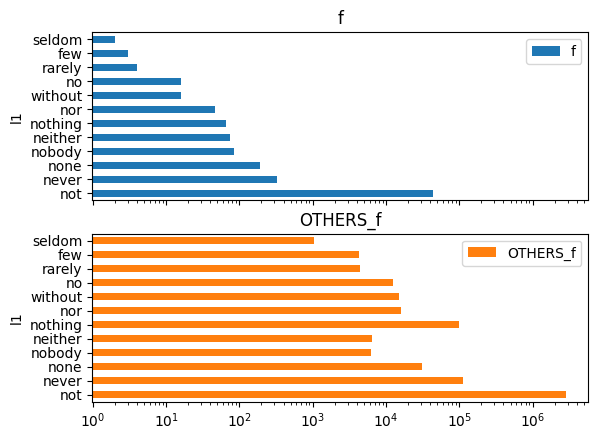

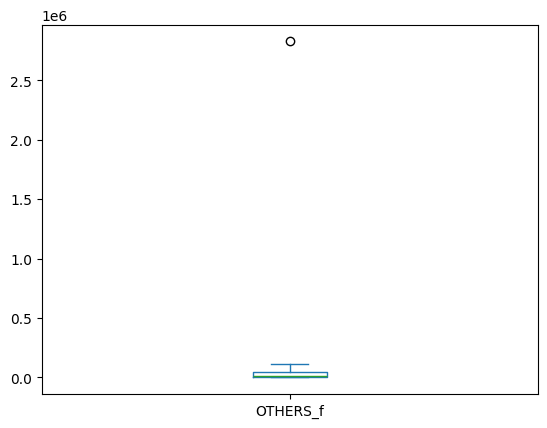

In [ ]:
# %%

am_trig_exactly.filter(['f', 'OTHERS_f']).plot(
    kind='barh', logx=True, subplots=True)
am_trig_exactly.filter(['OTHERS_f']).plot(kind='box')

In [ ]:
# %%

display(am_trig_exactly
        .sort_values('f', ascending=False))
style_crosstab(am_trig_exactly.reset_index(),
               ['l1'], ['l2'], 'f', aggfunc='sum')

,key,f,dP1,LRC,G2,l2,f1,f2,N,exp_f,unexp_f,unexp_r,deltaP_max,deltaP_mean,dP2,polarity,polar_int,l2_exactly,OTHERS_f
l1,,,,,,,,,,,,,,,,,,,
not,not~exactly,43114,0.081502,2.253632,4660.321376,exactly,2871807,43944,3188297,39581.847867,3532.152133,12.206156,0.081502,0.046946,0.012390,neg,-1,True,2828693
never,never~exactly,326,-0.027807,-1.860587,-1449.313310,exactly,111089,43944,3188297,1531.129320,-1205.129320,-0.270510,-0.011240,-0.019524,-0.011240,neg,-1,True,110763
none,none~exactly,193,-0.005550,-0.648088,-171.869137,exactly,31453,43944,3188297,433.513764,-240.513764,-0.802449,-0.005550,-0.006636,-0.007723,neg,-1,True,31260
nobody,nobody~exactly,84,-0.000086,0.000000,-0.163267,exactly,6365,43944,3188297,87.728201,-3.728201,-1.000000,-0.000086,-0.000336,-0.000587,neg,-1,True,6281
neither,neither~exactly,74,-0.000369,0.000000,-3.066359,exactly,6528,43944,3188297,89.974815,-15.974815,-1.000000,-0.000369,-0.001410,-0.002452,neg,-1,True,6454
nothing,nothing~exactly,66,-0.030443,-3.568499,-2295.446438,exactly,100513,43944,3188297,1385.361299,-1319.361299,-0.050024,-0.013554,-0.021998,-0.013554,neg,-1,True,100447
nor,nor~exactly,46,-0.004003,-1.239711,-205.825802,exactly,15925,43944,3188297,219.492789,-173.492789,-0.265141,-0.004003,-0.007476,-0.010949,neg,-1,True,15879
without,without~exactly,16,-0.004346,-2.069815,-298.390874,exactly,14825,43944,3188297,204.331591,-188.331591,-0.084957,-0.004346,-0.008554,-0.012763,neg,-1,True,14809
no,no~exactly,16,-0.003586,-1.815452,-237.492710,exactly,12438,43944,3188297,171.431793,-155.431793,-0.102939,-0.003586,-0.008066,-0.012545,neg,-1,True,12422


formatted table saved as html: imports/tables/l1_f-sum_l2_color-table.2025-01-22_03.html


l2,exactly
l1,
not,"43,114"
never,326
none,193
nobody,84
neither,74
nothing,66
nor,46
no,16
without,16


In [ ]:
# %%

# df_super_pos = pd.read_parquet(POS_SUPER_PARQ, columns=[
#                              'adv_form_lower', 'adj_form_lower']).assign()
# df_super = pd.concat([df_super_neg, df_super_pos])

save_latex_table(
    format_zeros(
        am_trig_exactly
        .reset_index()
        .rename(
            columns={'l1': 'trigger lemma', 'l2': 'adverb'})
        .set_index(['trigger lemma', 'adverb'])
        .filter(['LRC', 'dP1', 'dP2', 'G2'])
        .stack().unstack(['adverb', -1])
        .sort_values(('exactly', 'LRC'), ascending=False)
        .style
        .format(precision=2, thousands=',', escape='latex')
        .background_gradient('RdBu_r')
    ),
    label='trigger-exactly-AM',
    caption='Negative Trigger$\sim$<i>Exactly</i> Association',
    latex_path=WRITING_LINKS.joinpath(
        f'cluster/triggers/trigger-exactly_AM-rbdirect.{timestamp_today()}.tex')

)

Negative Trigger$\sim$<i>Exactly</i> Association
/share/compling/projects/sanpi/info/writing_links/cluster/triggers/trigger-exactly_AM-rbdirect.2025-01-22.tex


Stylized latex table saved as:
  cluster/triggers/trigger-exactly_AM-rbdirect.2025-01-22.tex



In [ ]:
# %%

for name, am_df in [('neg-super', am_trig_exactly), 
                    ('any-mirror', mir_am_trig_exactly), 
                    ('any-trigger', ALL_trig_exactly)]:
    display(save_html(set_my_style(
        (transform_counts(am_df.filter(['f', 'OTHERS_f', 'f1']))
         .sort_values('f1', ascending=False)),
        caption=('Square Root Transformed Trigger Frequencies<br/>'
                 'with <i>exactly</i> vs. other adverbs'),
        precision=1)
        .bar(axis=0, cmap='YlGnBu')
        .relabel_index(labels=['with <i>exactly</i>',
                               'with<u>out</u> <i>exactly</i>',
                               'Total'],
                       axis=1),
        subdir='triggers', stem=f'{name}-trigger-f_exactly-vs-others_bar'))

    save_latex_table(
        (transform_counts(
            am_df.filter(['f', 'OTHERS_f', 'f1']))
         .sort_values('f1', ascending=False)
         .style
         .background_gradient(axis=0, cmap='YlGnBu')
         .relabel_index(
            labels=['with <i>exactly</i>',
                    'with<u>out</u> <i>exactly</i>',
                    'Total'], axis=1)
         .format(precision=1, thousands=',', escape='latex')),
        caption=(r'Square Root Transformed Trigger Frequencies\\'
                 'with <i>exactly</i> vs. other adverbs'),
        label='trig-exactly-others',
        latex_path=WRITING_LINKS.joinpath(
            f'cluster/triggers/{name}-trigger_x_exactly-vs-others_freq.{timestamp_today()}.tex')
    )
    
    save_latex_table(
        format_zeros(
            am_trig_exactly
            .reset_index()
            .rename(
                columns={'l1': 'trigger lemma', 'l2': 'adverb'})
            .set_index(['trigger lemma', 'adverb'])
            .filter(['LRC', 'dP1', 'dP2', 'G2'])
            .stack().unstack(['adverb', -1])
            .sort_values(('exactly', 'LRC'), ascending=False)
            .style
            .format(precision=2, thousands=',', escape='latex')
            .background_gradient('RdBu_r')
        ),
        label='trigger-exactly-AM',
        caption=f'{name}: Trigger$\sim$<i>Exactly</i> Association',
        latex_path=WRITING_LINKS.joinpath(
            f'cluster/triggers/f{name}-trigger-exactly_AM.{timestamp_today()}.tex')

    )

html table saved as
  "imports/tables/triggers/neg-super-trigger-f_exactly-vs-others_bar.2025-01-22.html"


,with exactly,without exactly,Total
l1,,,
not,207.6,"1,681.9","1,694.6"
never,18.1,332.8,333.3
nothing,8.1,316.9,317.0
none,13.9,176.8,177.3
nor,6.8,126.0,126.2
without,4.0,121.7,121.8
no,4.0,111.5,111.5
neither,8.6,80.3,80.8
nobody,9.2,79.3,79.8


Square Root Transformed Trigger Frequencies\\with <i>exactly</i> vs. other adverbs
/share/compling/projects/sanpi/info/writing_links/cluster/triggers/neg-super-trigger_x_exactly-vs-others_freq.2025-01-22.tex


,f,OTHERS\_f,f1
L1,,,
not,207.639110,1681.871874,1694.640670
never,18.055470,332.810757,333.300165
nothing,8.124038,316.933747,317.037853
none,13.892444,176.804977,177.349937
nor,6.782330,126.011904,126.194295
without,4.000000,121.692235,121.757957
no,4.000000,111.454026,111.525782
neither,8.602325,80.336791,80.796040
nobody,9.165151,79.252760,79.780950


Stylized latex table saved as:
  cluster/triggers/neg-super-trigger_x_exactly-vs-others_freq.2025-01-22.tex

neg-super: Trigger$\sim$<i>Exactly</i> Association
/share/compling/projects/sanpi/info/writing_links/cluster/triggers/fneg-super-trigger-exactly_AM.2025-01-22.tex


Stylized latex table saved as:
  cluster/triggers/fneg-super-trigger-exactly_AM.2025-01-22.tex

html table saved as
  "imports/tables/triggers/any-mirror-trigger-f_exactly-vs-others_bar.2025-01-22.html"


,with exactly,without exactly,Total
l1,,,
something,2.4,556.4,556.4
or,5.4,552.2,552.2
all,8.2,493.9,493.9
never,18.1,332.8,333.3
some,1.4,328.1,328.1
nothing,8.1,316.2,316.3
often,2.2,287.3,287.3
always,4.0,286.7,286.8
sometimes,2.4,253.3,253.3


Square Root Transformed Trigger Frequencies\\with <i>exactly</i> vs. other adverbs
/share/compling/projects/sanpi/info/writing_links/cluster/triggers/any-mirror-trigger_x_exactly-vs-others_freq.2025-01-22.tex


,f,OTHERS\_f,f1
L1,,,
something,2.449490,556.440473,556.445864
or,5.385165,552.215538,552.241795
all,8.185353,493.857267,493.925096
never,18.055470,332.830287,333.319666
some,1.414214,328.073163,328.076211
nothing,8.124038,316.192979,316.297328
often,2.236068,287.287313,287.296015
always,4.000000,286.743788,286.771686
sometimes,2.449490,253.266658,253.278503


Stylized latex table saved as:
  cluster/triggers/any-mirror-trigger_x_exactly-vs-others_freq.2025-01-22.tex

any-mirror: Trigger$\sim$<i>Exactly</i> Association
/share/compling/projects/sanpi/info/writing_links/cluster/triggers/fany-mirror-trigger-exactly_AM.2025-01-22.tex


Stylized latex table saved as:
  cluster/triggers/fany-mirror-trigger-exactly_AM.2025-01-22.tex

html table saved as
  "imports/tables/triggers/any-trigger-trigger-f_exactly-vs-others_bar.2025-01-22.html"


,with exactly,without exactly,Total
l1,,,
not,207.6,"1,681.9","1,694.6"
something,2.4,556.4,556.4
or,5.4,552.2,552.2
all,8.2,493.9,493.9
never,18.1,332.8,333.3
some,1.4,328.1,328.1
nothing,8.1,316.9,317.0
often,2.2,287.3,287.3
always,4.0,286.7,286.8


Square Root Transformed Trigger Frequencies\\with <i>exactly</i> vs. other adverbs
/share/compling/projects/sanpi/info/writing_links/cluster/triggers/any-trigger-trigger_x_exactly-vs-others_freq.2025-01-22.tex


,f,OTHERS\_f,f1
L1,,,
not,207.639110,1681.871874,1694.640670
something,2.449490,556.440473,556.445864
or,5.385165,552.215538,552.241795
all,8.185353,493.857267,493.925096
never,18.055470,332.810757,333.300165
some,1.414214,328.073163,328.076211
nothing,8.124038,316.936902,317.041007
often,2.236068,287.287313,287.296015
always,4.000000,286.743788,286.771686


Stylized latex table saved as:
  cluster/triggers/any-trigger-trigger_x_exactly-vs-others_freq.2025-01-22.tex

any-trigger: Trigger$\sim$<i>Exactly</i> Association
/share/compling/projects/sanpi/info/writing_links/cluster/triggers/fany-trigger-trigger-exactly_AM.2025-01-22.tex


Stylized latex table saved as:
  cluster/triggers/fany-trigger-trigger-exactly_AM.2025-01-22.tex



In [ ]:
# %%

for name, am_df in [('neg-super', am_trig_exactly), 
                    ('any-mirror', mir_am_trig_exactly), 
                    ('any-trigger', ALL_trig_exactly)]:
    display(save_html(set_my_style(
        (transform_counts(am_df.filter(['f', 'OTHERS_f', 'f1']))
         .sort_values('f1', ascending=False)),
        caption=('Square Root Transformed Trigger Frequencies<br/>'
                 'with <i>exactly</i> vs. other adverbs'),
        precision=1)
        .bar(axis=0, cmap='YlGnBu')
        .relabel_index(labels=['with <i>exactly</i>',
                               'with<u>out</u> <i>exactly</i>',
                               'Total'],
                       axis=1),
        subdir='triggers', stem=f'{name}-trigger-f_exactly-vs-others_bar'))

    save_latex_table(
        (transform_counts(
            am_df.filter(['f', 'OTHERS_f', 'f1']))
         .sort_values('f1', ascending=False)
         .style
         .background_gradient(axis=0, cmap='YlGnBu')
         .relabel_index(
            labels=['with <i>exactly</i>',
                    'with<u>out</u> <i>exactly</i>',
                    'Total'], axis=1)
         .format(precision=1, thousands=',', escape='latex')),
        caption=(r'Square Root Transformed Trigger Frequencies\\'
                 'with <i>exactly</i> vs. other adverbs'),
        label='trig-exactly-others',
        latex_path=WRITING_LINKS.joinpath(
            f'cluster/triggers/{name}-trigger_x_exactly-vs-others_freq.{timestamp_today()}.tex')
    )
    
    save_latex_table(
        format_zeros(
            am_trig_exactly
            .reset_index()
            .rename(
                columns={'l1': 'trigger lemma', 'l2': 'adverb'})
            .set_index(['trigger lemma', 'adverb'])
            .filter(['LRC', 'dP1', 'dP2', 'G2'])
            .stack().unstack(['adverb', -1])
            .sort_values(('exactly', 'LRC'), ascending=False)
            .style
            .format(precision=2, thousands=',', escape='latex')
            .background_gradient('RdBu_r')
        ),
        label='trigger-exactly-AM',
        caption=f'{name}: Trigger$\sim$<i>Exactly</i> Association',
        latex_path=WRITING_LINKS.joinpath(
            f'cluster/triggers/{name}-trigger-exactly_AM.{timestamp_today()}.tex')

    )

html table saved as
  "imports/tables/triggers/neg-super-trigger-f_exactly-vs-others_bar.2025-01-22.html"


,with exactly,without exactly,Total
l1,,,
not,207.6,"1,681.9","1,694.6"
never,18.1,332.8,333.3
nothing,8.1,316.9,317.0
none,13.9,176.8,177.3
nor,6.8,126.0,126.2
without,4.0,121.7,121.8
no,4.0,111.5,111.5
neither,8.6,80.3,80.8
nobody,9.2,79.3,79.8


Square Root Transformed Trigger Frequencies\\with <i>exactly</i> vs. other adverbs
/share/compling/projects/sanpi/info/writing_links/cluster/triggers/neg-super-trigger_x_exactly-vs-others_freq.2025-01-22.tex


,f,OTHERS\_f,f1
L1,,,
not,207.639110,1681.871874,1694.640670
never,18.055470,332.810757,333.300165
nothing,8.124038,316.933747,317.037853
none,13.892444,176.804977,177.349937
nor,6.782330,126.011904,126.194295
without,4.000000,121.692235,121.757957
no,4.000000,111.454026,111.525782
neither,8.602325,80.336791,80.796040
nobody,9.165151,79.252760,79.780950


Stylized latex table saved as:
  cluster/triggers/neg-super-trigger_x_exactly-vs-others_freq.2025-01-22.tex

neg-super: Trigger$\sim$<i>Exactly</i> Association
/share/compling/projects/sanpi/info/writing_links/cluster/triggers/neg-super-trigger-exactly_AM.2025-01-22.tex


Stylized latex table saved as:
  cluster/triggers/neg-super-trigger-exactly_AM.2025-01-22.tex

html table saved as
  "imports/tables/triggers/any-mirror-trigger-f_exactly-vs-others_bar.2025-01-22.html"


,with exactly,without exactly,Total
l1,,,
something,2.4,556.4,556.4
or,5.4,552.2,552.2
all,8.2,493.9,493.9
never,18.1,332.8,333.3
some,1.4,328.1,328.1
nothing,8.1,316.2,316.3
often,2.2,287.3,287.3
always,4.0,286.7,286.8
sometimes,2.4,253.3,253.3


Square Root Transformed Trigger Frequencies\\with <i>exactly</i> vs. other adverbs
/share/compling/projects/sanpi/info/writing_links/cluster/triggers/any-mirror-trigger_x_exactly-vs-others_freq.2025-01-22.tex


,f,OTHERS\_f,f1
L1,,,
something,2.449490,556.440473,556.445864
or,5.385165,552.215538,552.241795
all,8.185353,493.857267,493.925096
never,18.055470,332.830287,333.319666
some,1.414214,328.073163,328.076211
nothing,8.124038,316.192979,316.297328
often,2.236068,287.287313,287.296015
always,4.000000,286.743788,286.771686
sometimes,2.449490,253.266658,253.278503


Stylized latex table saved as:
  cluster/triggers/any-mirror-trigger_x_exactly-vs-others_freq.2025-01-22.tex

any-mirror: Trigger$\sim$<i>Exactly</i> Association
/share/compling/projects/sanpi/info/writing_links/cluster/triggers/any-mirror-trigger-exactly_AM.2025-01-22.tex


Stylized latex table saved as:
  cluster/triggers/any-mirror-trigger-exactly_AM.2025-01-22.tex

html table saved as
  "imports/tables/triggers/any-trigger-trigger-f_exactly-vs-others_bar.2025-01-22.html"


,with exactly,without exactly,Total
l1,,,
not,207.6,"1,681.9","1,694.6"
something,2.4,556.4,556.4
or,5.4,552.2,552.2
all,8.2,493.9,493.9
never,18.1,332.8,333.3
some,1.4,328.1,328.1
nothing,8.1,316.9,317.0
often,2.2,287.3,287.3
always,4.0,286.7,286.8


Square Root Transformed Trigger Frequencies\\with <i>exactly</i> vs. other adverbs
/share/compling/projects/sanpi/info/writing_links/cluster/triggers/any-trigger-trigger_x_exactly-vs-others_freq.2025-01-22.tex


,f,OTHERS\_f,f1
L1,,,
not,207.639110,1681.871874,1694.640670
something,2.449490,556.440473,556.445864
or,5.385165,552.215538,552.241795
all,8.185353,493.857267,493.925096
never,18.055470,332.810757,333.300165
some,1.414214,328.073163,328.076211
nothing,8.124038,316.936902,317.041007
often,2.236068,287.287313,287.296015
always,4.000000,286.743788,286.771686


Stylized latex table saved as:
  cluster/triggers/any-trigger-trigger_x_exactly-vs-others_freq.2025-01-22.tex

any-trigger: Trigger$\sim$<i>Exactly</i> Association
/share/compling/projects/sanpi/info/writing_links/cluster/triggers/any-trigger-trigger-exactly_AM.2025-01-22.tex


Stylized latex table saved as:
  cluster/triggers/any-trigger-trigger-exactly_AM.2025-01-22.tex



In [ ]:
# %%

for name, am_df in [('neg-super', am_trig_exactly), 
                    ('any-mirror', mir_am_trig_exactly), 
                    ('any-trigger', ALL_trig_exactly)]:
    display(save_html(set_my_style(
        (transform_counts(am_df.filter(['f', 'OTHERS_f', 'f1']))
         .sort_values('f1', ascending=False)),
        caption=('Square Root Transformed Trigger Frequencies<br/>'
                 'with <i>exactly</i> vs. other adverbs'),
        precision=1)
        .bar(axis=0, cmap='YlGnBu')
        .relabel_index(labels=['with <i>exactly</i>',
                               'with<u>out</u> <i>exactly</i>',
                               'Total'],
                       axis=1),
        subdir='triggers', stem=f'{name}-trigger-f_exactly-vs-others_bar'))

    save_latex_table(
        (transform_counts(
            am_df.filter(['f', 'OTHERS_f', 'f1']))
         .sort_values('f1', ascending=False)
         .style
         .background_gradient(axis=0, cmap='YlGnBu')
         .relabel_index(
            labels=['with <i>exactly</i>',
                    'with<u>out</u> <i>exactly</i>',
                    'Total'], axis=1)
         .format(precision=1, thousands=',', escape='latex')),
        caption=(r'Square Root Transformed Trigger Frequencies\\'
                 'with <i>exactly</i> vs. other adverbs'),
        label='trig-exactly-others',
        latex_path=WRITING_LINKS.joinpath(
            f'cluster/triggers/{name}-trigger_x_exactly-vs-others_freq.{timestamp_today()}.tex')
    )
    
    save_latex_table(
        format_zeros(
            am_df
            .reset_index()
            .rename(
                columns={'l1': 'trigger lemma', 'l2': 'adverb'})
            .set_index(['trigger lemma', 'adverb'])
            .filter(['LRC', 'dP1', 'dP2', 'G2'])
            .stack().unstack(['adverb', -1])
            .sort_values(('exactly', 'LRC'), ascending=False)
            .style
            .format(precision=2, thousands=',', escape='latex')
            .background_gradient('RdBu_r')
        ),
        label='trigger-exactly-AM',
        caption=f'{name}: Trigger$\sim$<i>Exactly</i> Association',
        latex_path=WRITING_LINKS.joinpath(
            f'cluster/triggers/{name}-trigger-exactly_AM.{timestamp_today()}.tex')

    )

html table saved as
  "imports/tables/triggers/neg-super-trigger-f_exactly-vs-others_bar.2025-01-22.html"


,with exactly,without exactly,Total
l1,,,
not,207.6,"1,681.9","1,694.6"
never,18.1,332.8,333.3
nothing,8.1,316.9,317.0
none,13.9,176.8,177.3
nor,6.8,126.0,126.2
without,4.0,121.7,121.8
no,4.0,111.5,111.5
neither,8.6,80.3,80.8
nobody,9.2,79.3,79.8


Square Root Transformed Trigger Frequencies\\with <i>exactly</i> vs. other adverbs
/share/compling/projects/sanpi/info/writing_links/cluster/triggers/neg-super-trigger_x_exactly-vs-others_freq.2025-01-22.tex


,f,OTHERS\_f,f1
L1,,,
not,207.639110,1681.871874,1694.640670
never,18.055470,332.810757,333.300165
nothing,8.124038,316.933747,317.037853
none,13.892444,176.804977,177.349937
nor,6.782330,126.011904,126.194295
without,4.000000,121.692235,121.757957
no,4.000000,111.454026,111.525782
neither,8.602325,80.336791,80.796040
nobody,9.165151,79.252760,79.780950


Stylized latex table saved as:
  cluster/triggers/neg-super-trigger_x_exactly-vs-others_freq.2025-01-22.tex

neg-super: Trigger$\sim$<i>Exactly</i> Association
/share/compling/projects/sanpi/info/writing_links/cluster/triggers/neg-super-trigger-exactly_AM.2025-01-22.tex


Stylized latex table saved as:
  cluster/triggers/neg-super-trigger-exactly_AM.2025-01-22.tex

html table saved as
  "imports/tables/triggers/any-mirror-trigger-f_exactly-vs-others_bar.2025-01-22.html"


,with exactly,without exactly,Total
l1,,,
something,2.4,556.4,556.4
or,5.4,552.2,552.2
all,8.2,493.9,493.9
never,18.1,332.8,333.3
some,1.4,328.1,328.1
nothing,8.1,316.2,316.3
often,2.2,287.3,287.3
always,4.0,286.7,286.8
sometimes,2.4,253.3,253.3


Square Root Transformed Trigger Frequencies\\with <i>exactly</i> vs. other adverbs
/share/compling/projects/sanpi/info/writing_links/cluster/triggers/any-mirror-trigger_x_exactly-vs-others_freq.2025-01-22.tex


,f,OTHERS\_f,f1
L1,,,
something,2.449490,556.440473,556.445864
or,5.385165,552.215538,552.241795
all,8.185353,493.857267,493.925096
never,18.055470,332.830287,333.319666
some,1.414214,328.073163,328.076211
nothing,8.124038,316.192979,316.297328
often,2.236068,287.287313,287.296015
always,4.000000,286.743788,286.771686
sometimes,2.449490,253.266658,253.278503


Stylized latex table saved as:
  cluster/triggers/any-mirror-trigger_x_exactly-vs-others_freq.2025-01-22.tex

any-mirror: Trigger$\sim$<i>Exactly</i> Association
/share/compling/projects/sanpi/info/writing_links/cluster/triggers/any-mirror-trigger-exactly_AM.2025-01-22.tex


Stylized latex table saved as:
  cluster/triggers/any-mirror-trigger-exactly_AM.2025-01-22.tex

html table saved as
  "imports/tables/triggers/any-trigger-trigger-f_exactly-vs-others_bar.2025-01-22.html"


,with exactly,without exactly,Total
l1,,,
not,207.6,"1,681.9","1,694.6"
something,2.4,556.4,556.4
or,5.4,552.2,552.2
all,8.2,493.9,493.9
never,18.1,332.8,333.3
some,1.4,328.1,328.1
nothing,8.1,316.9,317.0
often,2.2,287.3,287.3
always,4.0,286.7,286.8


Square Root Transformed Trigger Frequencies\\with <i>exactly</i> vs. other adverbs
/share/compling/projects/sanpi/info/writing_links/cluster/triggers/any-trigger-trigger_x_exactly-vs-others_freq.2025-01-22.tex


,f,OTHERS\_f,f1
L1,,,
not,207.639110,1681.871874,1694.640670
something,2.449490,556.440473,556.445864
or,5.385165,552.215538,552.241795
all,8.185353,493.857267,493.925096
never,18.055470,332.810757,333.300165
some,1.414214,328.073163,328.076211
nothing,8.124038,316.936902,317.041007
often,2.236068,287.287313,287.296015
always,4.000000,286.743788,286.771686


Stylized latex table saved as:
  cluster/triggers/any-trigger-trigger_x_exactly-vs-others_freq.2025-01-22.tex

any-trigger: Trigger$\sim$<i>Exactly</i> Association
/share/compling/projects/sanpi/info/writing_links/cluster/triggers/any-trigger-trigger-exactly_AM.2025-01-22.tex


Stylized latex table saved as:
  cluster/triggers/any-trigger-trigger-exactly_AM.2025-01-22.tex



# %% [markdown]

 ## Just *exactly*, but more info

In [ ]:
exactly_df = pd.read_parquet(
    NEG_SUPER_PARQ,
    columns=['bigram_id', 'hit_id', 'all_forms_lower',
             'trigger_lemma', 'trigger_lower', 'bigram_lower',
             'adv_form_lower', 'adj_form_lower', 'adj_lemma',
             'neg_head', 'neg_deprel', 'category', 'pattern'],
    # filters=[('adv_form_lower', 'in', SPECIAL_ADV)]
    filters=[('adv_form_lower', '==', 'exactly')]
)
exactly_df = rename_trigger_dep_info(exactly_df)
exactly_df.describe()

# exactly_trig_f = get_joint_f(exactly_df,l2='bigram_lower').reset_index()
exactly_df['f'] = exactly_df.all_forms_lower.map(
    exactly_df.value_counts(
        'all_forms_lower').astype('int64').to_dict())
exactly_df['f1'] = exactly_df.trigger_lemma.map(
    exactly_df.value_counts(
        'trigger_lemma').astype('int64').to_dict())
display(set_my_style(exactly_df.filter(
    like='f').drop_duplicates().nlargest(10, 'f')))

display(style_crosstab(exactly_df, ['trigger_lemma'],
                       ['adv_form_lower', 'neg_head'],
                       'f', aggfunc='sum',
                       axis=None,
                       group=False,
                       cmap='purple_rain'))

,all_forms_lower,adv_form_lower,adj_form_lower,f,f1
hit_id,,,,,
apw_eng_19970527_0859_11:13-14-15,not_exactly_sure,exactly,sure,"6,666","42,997"
apw_eng_19980629_0616_1:10-11-12,n't_exactly_sure,exactly,sure,"2,032","42,997"
apw_eng_19971009_1039_7:3-4-5,not_exactly_clear,exactly,clear,"1,133","42,997"
apw_eng_19980612_0578_5:3-4-5,not_exactly_true,exactly,true,"1,059","42,997"
apw_eng_19970809_0799_6:7-8-9,n't_exactly_new,exactly,new,773,"42,997"
apw_eng_19971211_1307_41:4-5-6,not_exactly_new,exactly,new,570,"42,997"
apw_eng_19980307_0810_15:7-8-9,n't_exactly_easy,exactly,easy,533,"42,997"
apw_eng_20010131_0799_6:12-13-14,not_exactly_easy,exactly,easy,511,"42,997"
apw_eng_19980102_0832_3:3-4-5,n't_exactly_clear,exactly,clear,497,"42,997"


formatted table saved as html: imports/tables/trigger_lemma_f-sum_adv_form_lower-neg_head_color-table.2025-01-22_03.html


# %% [markdown]

 The `am_notebooks.style_crosstab()` method applies table-wide formatting via `am_notebooks.set_my_style()`
 that does not convert to latex properly.

 To get around this, return the crosstabulated table using `return_cross_df=True`,
 and apply the `background_gradient` directly.

 Remember that `background_gradient` applies to individual columns by default:
 use `axis=None` to apply same gradient to whole table.

In [ ]:
f_ct_df = style_crosstab(
    exactly_df, ['trigger_lemma'],
    ['adv_form_lower', 'neg_head'],
    'f', aggfunc='sum',
    return_cross_df=True
).fillna(0).convert_dtypes()

sty = (f_ct_df.style
       .background_gradient(
           #    cmap='YlGnBu',
           axis=None, vmax=25000)
       .format(precision=0, thousands=','))

# %% [markdown]

 If running on the cluster, set latex_path explicitly. Else, just pass subdir and stem

 `latex_path=SANPI_HOME.joinpath(f'info/writing_links/cluster/trigger-x-exactly_freq.{timestamp_today()}.tex')`

In [ ]:
latex_path = SANPI_HOME.joinpath(
    f'info/writing_links/cluster/trigger_x_exactly-head_freq.{timestamp_today()}.tex')
save_latex_table(
    sty, latex_path=latex_path,
    label='trig-exactly-head-f',
    caption=('Superset Negative Trigger Co-Occurences with <i>Exactly</i> Bigrams,'
             r'\\Grouped by head of trigger dependency'))

Superset Negative Trigger Co-Occurences with <i>Exactly</i> Bigrams,\\Grouped by head of trigger dependency
/share/compling/projects/sanpi/info/writing_links/cluster/trigger_x_exactly-head_freq.2025-01-22.tex


Stylized latex table saved as:
  cluster/trigger_x_exactly-head_freq.2025-01-22.tex



# %% [markdown]

 If running on the cluster, set latex_path explicitly. Else, just pass subdir and stem

 `latex_path=SANPI_HOME.joinpath(f'info/writing_links/cluster/trigger-x-exactly_freq.{timestamp_today()}.tex')`

In [ ]:
latex_path = SANPI_HOME.joinpath(
    f'info/writing_links/cluster/trigger_x_exactly-head_freq.{timestamp_today()}.tex')
save_latex_table(
    format_zeros(sty), latex_path=latex_path,
    label='trig-exactly-head-f',
    caption=('Superset Negative Trigger Co-Occurences with <i>Exactly</i> Bigrams,'
             r'\\Grouped by head of trigger dependency'))

Superset Negative Trigger Co-Occurences with <i>Exactly</i> Bigrams,\\Grouped by head of trigger dependency
/share/compling/projects/sanpi/info/writing_links/cluster/trigger_x_exactly-head_freq.2025-01-22.tex


Stylized latex table saved as:
  cluster/trigger_x_exactly-head_freq.2025-01-22.tex



In [ ]:
# %%

exactly_df = exactly_df.join(
    transform_counts(exactly_df.filter(['f', 'f1', 'f2'])),
    rsuffix='_sqrt')
display(style_crosstab(exactly_df, ['trigger_lemma'],
                       ['adv_form_lower', 'neg_head'],
                       'f_sqrt',
                       aggfunc='sum',
                       axis=None,
                       group=False,
                       cmap='RdPu'))

formatted table saved as html: imports/tables/trigger_lemma_f_sqrt-sum_adv_form_lower-neg_head_color-table.2025-01-22_03.html
